<a href="https://colab.research.google.com/github/prabutlv/Projects-/blob/main/AdEase_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pmdarima prophet statsmodels scikit-learn matplotlib seaborn joblib


In [3]:
import os, gc, math, warnings
warnings.filterwarnings("ignore")

import polars as pl
import pandas as pd
import numpy as np
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_absolute_error as mae,
    mean_squared_error as mse,
    mean_absolute_percentage_error as mape
)


from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

'''# evaluation
def mape(a, f):
    a = np.array(a); f = np.array(f)
    mask = a != 0
    if mask.sum()==0:
        return np.nan
    return np.mean(np.abs((a[mask]-f[mask]) / a[mask]))*100'''


'# evaluation\ndef mape(a, f):\n    a = np.array(a); f = np.array(f)\n    mask = a != 0\n    if mask.sum()==0:\n        return np.nan\n    return np.mean(np.abs((a[mask]-f[mask]) / a[mask]))*100'

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!gdown 1-2Z_qEP6vnRyWTOHgLQ6v_w9eWCQbwkz
!gdow 1uWrrobt_Izydgq7EK20wXtY8D-V0nYDc

Downloading...
From (original): https://drive.google.com/uc?id=1-2Z_qEP6vnRyWTOHgLQ6v_w9eWCQbwkz
From (redirected): https://drive.google.com/uc?id=1-2Z_qEP6vnRyWTOHgLQ6v_w9eWCQbwkz&confirm=t&uuid=98ff1ded-e7c9-40a1-b633-ded962854b0a
To: /content/Copy of train_1.csv
100% 278M/278M [00:06<00:00, 45.5MB/s]
/bin/bash: line 1: gdow: command not found


In [84]:
'''with open("Copy of train_1.csv", "r", encoding="utf-8") as f:
    header = f.readline().strip()
cols = header.split(",")
len(cols), cols[:10]'''


'with open("Copy of train_1.csv", "r", encoding="utf-8") as f:\n    header = f.readline().strip()\ncols = header.split(",")\nlen(cols), cols[:10]'

In [6]:
import csv

with open("Copy of train_1.csv", "r", encoding="utf-8") as f:
    reader = csv.reader(f)
    cols = next(reader)

len(cols), cols[:10]


(551,
 ['Page',
  '2015-07-01',
  '2015-07-02',
  '2015-07-03',
  '2015-07-04',
  '2015-07-05',
  '2015-07-06',
  '2015-07-07',
  '2015-07-08',
  '2015-07-09'])

In [7]:
schema = {col: pl.Utf8 for col in cols}


In [8]:
train = pl.read_csv(
    "/content/Copy of train_1.csv",
    schema_overrides=schema,
    ignore_errors=True,
    low_memory=True
)
print(train.shape)
# check first cols
print(train.columns[:10])


(145063, 551)
['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09']


In [9]:
train.head()

shape: (5, 551)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Page      ┆ 2015-07-0 ┆ 2015-07-0 ┆ 2015-07-0 ┆ … ┆ 2016-12-2 ┆ 2016-12-2 ┆ 2016-12-3 ┆ 2016-12- │
│ ---       ┆ 1         ┆ 2         ┆ 3         ┆   ┆ 8         ┆ 9         ┆ 0         ┆ 31       │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ str       ┆ str       ┆ str       ┆   ┆ str       ┆ str       ┆ str       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2NE1_zh.w ┆ 18        ┆ 11        ┆ 5         ┆ … ┆ 22        ┆ 19        ┆ 18        ┆ 20       │
│ ikipedia. ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ org_all-a ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ cce…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2PM_zh.wi ┆ 11        ┆ 14        ┆ 15        ┆ … ┆ 52        ┆ 45        ┆ 26        ┆ 20       │
│ kipedia.o ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ rg_all-ac ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ces…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3C_zh.wik ┆ 1         ┆ 0         ┆ 1         ┆ … ┆ 6         ┆ 3         ┆ 4         ┆ 17       │
│ ipedia.or ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ g_all-acc ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ess…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 4minute_z ┆ 35        ┆ 13        ┆ 10        ┆ … ┆ 17        ┆ 19        ┆ 10        ┆ 11       │
│ h.wikiped ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ia.org_al ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ l-a…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 52_Hz_I_L ┆ null      ┆ null      ┆ null      ┆ … ┆ 27        ┆ 13        ┆ 36        ┆ 10       │
│ ove_You_z ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ h.wikiped ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ia.…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [10]:
exog = pd.read_csv('/content/drive/MyDrive/Copy of Exog_Campaign_eng')
print(exog.shape)
exog.head()

(550, 1)


Exog
0     0
1     0
2     0
3     0
4     0

In [11]:
train.schema

Schema([('Page', String),
        ('2015-07-01', String),
        ('2015-07-02', String),
        ('2015-07-03', String),
        ('2015-07-04', String),
        ('2015-07-05', String),
        ('2015-07-06', String),
        ('2015-07-07', String),
        ('2015-07-08', String),
        ('2015-07-09', String),
        ('2015-07-10', String),
        ('2015-07-11', String),
        ('2015-07-12', String),
        ('2015-07-13', String),
        ('2015-07-14', String),
        ('2015-07-15', String),
        ('2015-07-16', String),
        ('2015-07-17', String),
        ('2015-07-18', String),
        ('2015-07-19', String),
        ('2015-07-20', String),
        ('2015-07-21', String),
        ('2015-07-22', String),
        ('2015-07-23', String),
        ('2015-07-24', String),
        ('2015-07-25', String),
        ('2015-07-26', String),
        ('2015-07-27', String),
        ('2015-07-28', String),
        ('2015-07-29', String),
        ('2015-07-30', String),
        ('2015

In [12]:
train.dtypes

[String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 

In [13]:
train.null_count()

shape: (1, 551)
┌──────┬────────────┬────────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ Page ┆ 2015-07-01 ┆ 2015-07-02 ┆ 2015-07-03 ┆ … ┆ 2016-12-28 ┆ 2016-12-2 ┆ 2016-12-3 ┆ 2016-12-3 │
│ ---  ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---        ┆ 9         ┆ 0         ┆ 1         │
│ u32  ┆ u32        ┆ u32        ┆ u32        ┆   ┆ u32        ┆ ---       ┆ ---       ┆ ---       │
│      ┆            ┆            ┆            ┆   ┆            ┆ u32       ┆ u32       ┆ u32       │
╞══════╪════════════╪════════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 0    ┆ 20740      ┆ 20816      ┆ 20544      ┆ … ┆ 3822       ┆ 3826      ┆ 3635      ┆ 3465      │
└──────┴────────────┴────────────┴────────────┴───┴────────────┴───────────┴───────────┴───────────┘

In [14]:
train.null_count().select((pl.all()/train.height * 100).round(2))

shape: (1, 551)
┌──────┬────────────┬────────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ Page ┆ 2015-07-01 ┆ 2015-07-02 ┆ 2015-07-03 ┆ … ┆ 2016-12-28 ┆ 2016-12-2 ┆ 2016-12-3 ┆ 2016-12-3 │
│ ---  ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---        ┆ 9         ┆ 0         ┆ 1         │
│ f64  ┆ f64        ┆ f64        ┆ f64        ┆   ┆ f64        ┆ ---       ┆ ---       ┆ ---       │
│      ┆            ┆            ┆            ┆   ┆            ┆ f64       ┆ f64       ┆ f64       │
╞══════╪════════════╪════════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 0.0  ┆ 14.3       ┆ 14.35      ┆ 14.16      ┆ … ┆ 2.63       ┆ 2.64      ┆ 2.51      ┆ 2.39      │
└──────┴────────────┴────────────┴────────────┴───┴────────────┴───────────┴───────────┴───────────┘

In [15]:
train.describe()


shape: (9, 552)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ Page      ┆ 2015-07-0 ┆ 2015-07-0 ┆ … ┆ 2016-12-2 ┆ 2016-12-2 ┆ 2016-12-3 ┆ 2016-12- │
│ ---       ┆ ---       ┆ 1         ┆ 2         ┆   ┆ 8         ┆ 9         ┆ 0         ┆ 31       │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆ str       ┆   ┆ str       ┆ str       ┆ str       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 145063    ┆ 124323    ┆ 124247    ┆ … ┆ 141241    ┆ 141237    ┆ 141428    ┆ 141598   │
│ null_coun ┆ 0         ┆ 20740     ┆ 20816     ┆ … ┆ 3822      ┆ 3826      ┆ 3635      ┆ 3465     │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ std       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ min       ┆ !vote_en. ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0        │
│           ┆ wikipedia ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ .org_all- ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ acc…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 25%       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 50%       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 75%       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ max       ┆ ［Alexand ┆ 9999      ┆ 999       ┆ … ┆ 9996      ┆ 9996      ┆ 9996      ┆ 999      │
│           ┆ ros］_ja. ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ wikipedia ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ .org_…    ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [16]:
exog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Exog    550 non-null    int64
dtypes: int64(1)
memory usage: 4.4 KB


In [17]:
exog.describe()

Exog
count  550.000000
mean     0.098182
std      0.297831
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000

In [18]:
exog.isna().sum()

Exog    0
dtype: int64

In [19]:
page_col = train.columns[0]
train = train.rename({page_col: "page"})
print("page column:", train.columns[0])


page column: page


#Parse page into (title, language, access_type, access_origin) — do this in pandas for flexibility

In [20]:
def parse_page_name(s):
    # robust parser: fallback to None if missing pieces
    try:
        parts = s.split("_")
        title = parts[0] if len(parts)>0 else None
        lang_dom = parts[1] if len(parts)>1 else None
        access_type = parts[2] if len(parts)>2 else None
        access_origin = parts[3] if len(parts)>3 else None

        language = None
        if lang_dom and ".wikipedia" in lang_dom:
            language = lang_dom.split(".")[0]  # 'en', 'zh', etc.

        return title, language, access_type, access_origin
    except Exception:
        return None, None, None, None

# Convert only page column to pandas, parse, then attach back
page_series = train["page"].to_pandas()
parsed = page_series.apply(lambda x: pd.Series(parse_page_name(x),
                                               index=["title","language","access_type","access_origin"]))
# convert parsed to polars and horizontally concatenate
parsed_pl = pl.from_pandas(parsed)
train = parsed_pl.hstack(train)   # parsed columns come first
print(train.columns[:10])


['title', 'language', 'access_type', 'access_origin', 'page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05']


In [21]:
train.head()

shape: (5, 555)
┌─────────┬──────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ title   ┆ language ┆ access_typ ┆ access_ori ┆ … ┆ 2016-12-2 ┆ 2016-12-2 ┆ 2016-12-3 ┆ 2016-12-3 │
│ ---     ┆ ---      ┆ e          ┆ gin        ┆   ┆ 8         ┆ 9         ┆ 0         ┆ 1         │
│ str     ┆ str      ┆ ---        ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆          ┆ str        ┆ str        ┆   ┆ str       ┆ str       ┆ str       ┆ str       │
╞═════════╪══════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2NE1    ┆ zh       ┆ all-access ┆ spider     ┆ … ┆ 22        ┆ 19        ┆ 18        ┆ 20        │
│ 2PM     ┆ zh       ┆ all-access ┆ spider     ┆ … ┆ 52        ┆ 45        ┆ 26        ┆ 20        │
│ 3C      ┆ zh       ┆ all-access ┆ spider     ┆ … ┆ 6         ┆ 3         ┆ 4         ┆ 17        │
│ 4minute ┆ zh       ┆ all-access ┆ spider     ┆ … ┆ 17        ┆ 19        ┆ 10        ┆ 11        │
│ 52      ┆ null     ┆ I          ┆ Love       ┆ … ┆ 27        ┆ 13        ┆ 36        ┆ 10        │
└─────────┴──────────┴────────────┴────────────┴───┴───────────┴───────────┴───────────┴───────────┘

#Identify date columns

In [22]:
date_cols = [c for c in train.columns if c.startswith('20')]
print(f"Found {len(date_cols)} date columns. Start: {date_cols[:3]}, End: {date_cols[-3:]}")


Found 550 date columns. Start: ['2015-07-01', '2015-07-02', '2015-07-03'], End: ['2016-12-29', '2016-12-30', '2016-12-31']


#Chunked melt (Polars) — memory safe: write each chunk to parquet (or process per chunk)

In [23]:
OUT_DIR = "/content/tmp_melt_chunks"
os.makedirs(OUT_DIR, exist_ok=True)

chunk_pages = 10000   # tune this (5k is safe for Colab)
n_rows = train.shape[0]
chunks = math.ceil(n_rows / chunk_pages)
print("Total rows:", n_rows, "Chunks:", chunks)

for i in range(0, n_rows, chunk_pages):
    chunk = train.slice(i, chunk_pages)  # polars slice
    # unpivot (Polars uses `melt` alias `unpivot`)
    melted = chunk.melt(
        id_vars=['page','title','language','access_type','access_origin'],
        value_vars=date_cols,
        variable_name="date",
        value_name="views"
    )
    # cast types: date -> utf8 now; views -> float
    melted = melted.with_columns([
        pl.col("date").str.replace_all('"', ''),
        pl.col("views").cast(pl.Float64, strict=False)
    ])
    out_fn = os.path.join(OUT_DIR, f"melt_{i}.parquet")
    melted.write_parquet(out_fn)
    print(f"Written {out_fn} shape: {melted.shape}")
    del chunk, melted
    gc.collect()


Total rows: 145063 Chunks: 15
Written /content/tmp_melt_chunks/melt_0.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_10000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_20000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_30000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_40000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_50000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_60000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_70000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_80000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_90000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_100000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_110000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_120000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/me

In [24]:
sample = pl.read_parquet("/content/tmp_melt_chunks/melt_0.parquet")
sample.head()

shape: (5, 7)
┌──────────────────────────┬─────────┬──────────┬─────────────┬───────────────┬────────────┬───────┐
│ page                     ┆ title   ┆ language ┆ access_type ┆ access_origin ┆ date       ┆ views │
│ ---                      ┆ ---     ┆ ---      ┆ ---         ┆ ---           ┆ ---        ┆ ---   │
│ str                      ┆ str     ┆ str      ┆ str         ┆ str           ┆ str        ┆ f64   │
╞══════════════════════════╪═════════╪══════════╪═════════════╪═══════════════╪════════════╪═══════╡
│ 2NE1_zh.wikipedia.org_al ┆ 2NE1    ┆ zh       ┆ all-access  ┆ spider        ┆ 2015-07-01 ┆ 18.0  │
│ l-acce…                  ┆         ┆          ┆             ┆               ┆            ┆       │
│ 2PM_zh.wikipedia.org_all ┆ 2PM     ┆ zh       ┆ all-access  ┆ spider        ┆ 2015-07-01 ┆ 11.0  │
│ -acces…                  ┆         ┆          ┆             ┆               ┆            ┆       │
│ 3C_zh.wikipedia.org_all- ┆ 3C      ┆ zh       ┆ all-access  ┆ spider        ┆ 2015-07-01 ┆ 1.0   │
│ access…                  ┆         ┆          ┆             ┆               ┆            ┆       │
│ 4minute_zh.wikipedia.org ┆ 4minute ┆ zh       ┆ all-access  ┆ spider        ┆ 2015-07-01 ┆ 35.0  │
│ _all-a…                  ┆         ┆          ┆             ┆               ┆            ┆       │
│ 52_Hz_I_Love_You_zh.wiki ┆ 52      ┆ null     ┆ I           ┆ Love          ┆ 2015-07-01 ┆ null  │
│ pedia.…                  ┆         ┆          ┆             ┆               ┆            ┆       │
└──────────────────────────┴─────────┴──────────┴─────────────┴───────────────┴────────────┴───────┘

In [25]:
sample.sample(10)

shape: (10, 7)
┌────────────────┬────────────────┬──────────┬───────────────┬───────────────┬────────────┬────────┐
│ page           ┆ title          ┆ language ┆ access_type   ┆ access_origin ┆ date       ┆ views  │
│ ---            ┆ ---            ┆ ---      ┆ ---           ┆ ---           ┆ ---        ┆ ---    │
│ str            ┆ str            ┆ str      ┆ str           ┆ str           ┆ str        ┆ f64    │
╞════════════════╪════════════════╪══════════╪═══════════════╪═══════════════╪════════════╪════════╡
│ 邱淑貞_zh.wiki ┆ 邱淑貞         ┆ zh       ┆ all-access    ┆ spider        ┆ 2016-05-11 ┆ 16.0   │
│ pedia.org_all- ┆                ┆          ┆               ┆               ┆            ┆        │
│ acces…         ┆                ┆          ┆               ┆               ┆            ┆        │
│ 世界棒球經典賽 ┆ 世界棒球經典賽 ┆ zh       ┆ all-access    ┆ spider        ┆ 2016-11-11 ┆ 7.0    │
│ _zh.wikipedia. ┆                ┆          ┆               ┆               ┆            ┆        │
│ org_all-a…     ┆                ┆          ┆               ┆               ┆            ┆        │
│ T.O.P._zh.wiki ┆ T.O.P.         ┆ zh       ┆ all-access    ┆ spider        ┆ 2016-02-03 ┆ 20.0   │
│ pedia.org_all- ┆                ┆          ┆               ┆               ┆            ┆        │
│ ac…            ┆                ┆          ┆               ┆               ┆            ┆        │
│ A.J._Styles_en ┆ A.J.           ┆ null     ┆ en.wikipedia. ┆ desktop       ┆ 2015-08-07 ┆ 747.0  │
│ .wikipedia.org ┆                ┆          ┆ org           ┆               ┆            ┆        │
│ _d…            ┆                ┆          ┆               ┆               ┆            ┆        │
│ B.J._Penn_en.w ┆ B.J.           ┆ null     ┆ en.wikipedia. ┆ desktop       ┆ 2016-02-03 ┆ 1015.0 │
│ ikipedia.org_d ┆                ┆          ┆ org           ┆               ┆            ┆        │
│ es…            ┆                ┆          ┆               ┆               ┆            ┆        │
│ David_Blaine_e ┆ David          ┆ null     ┆ en.wikipedia. ┆ desktop       ┆ 2016-11-06 ┆ 902.0  │
│ n.wikipedia.or ┆                ┆          ┆ org           ┆               ┆            ┆        │
│ g_…            ┆                ┆          ┆               ┆               ┆            ┆        │
│ All_your_base_ ┆ All            ┆ null     ┆ base          ┆ are           ┆ 2016-03-22 ┆ 3.0    │
│ are_belong_to_ ┆                ┆          ┆               ┆               ┆            ┆        │
│ us…            ┆                ┆          ┆               ┆               ┆            ┆        │
│ 賀陳旦_zh.wiki ┆ 賀陳旦         ┆ zh       ┆ all-access    ┆ spider        ┆ 2015-11-22 ┆ 1.0    │
│ pedia.org_all- ┆                ┆          ┆               ┆               ┆            ┆        │
│ acces…         ┆                ┆          ┆               ┆               ┆            ┆        │
│ Hayao_Miyazaki ┆ Hayao          ┆ null     ┆ fr.wikipedia. ┆ desktop       ┆ 2015-11-26 ┆ 653.0  │
│ _fr.wikipedia. ┆                ┆          ┆ org           ┆               ┆            ┆        │
│ or…            ┆                ┆          ┆               ┆               ┆            ┆        │
│ Dolly_Parton_e ┆ Dolly          ┆ null     ┆ en.wikipedia. ┆ desktop       ┆ 2015-10-25 ┆ 1530.0 │
│ n.wikipedia.or ┆                ┆          ┆ org           ┆               ┆            ┆        │
│ g_…            ┆                ┆          ┆               ┆               ┆            ┆        │
└────────────────┴────────────────┴──────────┴───────────────┴───────────────┴────────────┴────────┘

#Load melted parquet in manageable partitions (or merge if you have memory)

In [26]:
import glob
parquet_files = sorted(glob.glob(OUT_DIR+"/*.parquet"))
# Example: load only English pages to pandas
dfs = []
for p in parquet_files:
    dfp = pl.read_parquet(p)
    # filter english rows in Polars (fast) before converting to pandas
    en = dfp.filter(pl.col("language") == "en")
    if en.height>0:
        dfs.append(en.to_pandas())
    del dfp, en
    gc.collect()

ts_en = pd.concat(dfs, ignore_index=True)
ts_en['date'] = pd.to_datetime(ts_en['date'])
#print(ts_en.head())
ts_en = ts_en.sort_values(['page','date'])
#print(ts_en.head())
print("English ts:", ts_en.shape)


English ts: (1330450, 7)


In [27]:
ts_en.head()

page  title language  \
624719  !vote_en.wikipedia.org_all-access_all-agents  !vote       en   
625438  !vote_en.wikipedia.org_all-access_all-agents  !vote       en   
626157  !vote_en.wikipedia.org_all-access_all-agents  !vote       en   
626876  !vote_en.wikipedia.org_all-access_all-agents  !vote       en   
627595  !vote_en.wikipedia.org_all-access_all-agents  !vote       en   

       access_type access_origin       date  views  
624719  all-access    all-agents 2015-07-01    3.0  
625438  all-access    all-agents 2015-07-02    4.0  
626157  all-access    all-agents 2015-07-03    7.0  
626876  all-access    all-agents 2015-07-04    4.0  
627595  all-access    all-agents 2015-07-05    4.0

#EDA (on a sample page or language-level)

<bound method NDFrame.head of page
Special:Search_en.wikipedia.org_all-access_all-agents                       1.304079e+09
Special:Search_en.wikipedia.org_desktop_all-agents                          1.011848e+09
Special:Search_en.wikipedia.org_mobile-web_all-agents                       2.921628e+08
Special:Book_en.wikipedia.org_all-access_all-agents                         1.339931e+08
Special:Book_en.wikipedia.org_desktop_all-agents                            1.332859e+08
                                                                                ...     
User:GoogleAnalitycsRoman2/google-api_en.wikipedia.org_all-access_spider    0.000000e+00
User:GoogleAnalitycsRoman5/google-api_en.wikipedia.org_all-access_spider    0.000000e+00
User:GoogleAnalitycsRoman6/google-api_en.wikipedia.org_all-access_spider    0.000000e+00
Ajol_en.wikipedia.org_all-access_all-agents                                 0.000000e+00
SriValli_en.wikipedia.org_all-access_all-agents                            

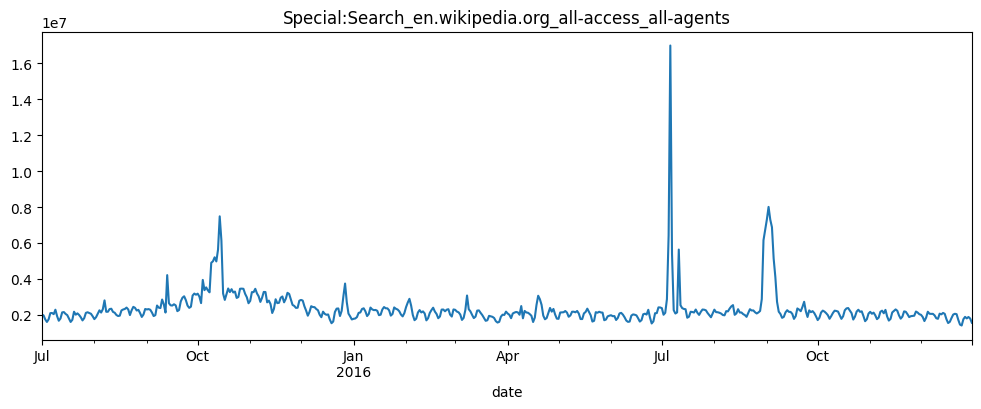

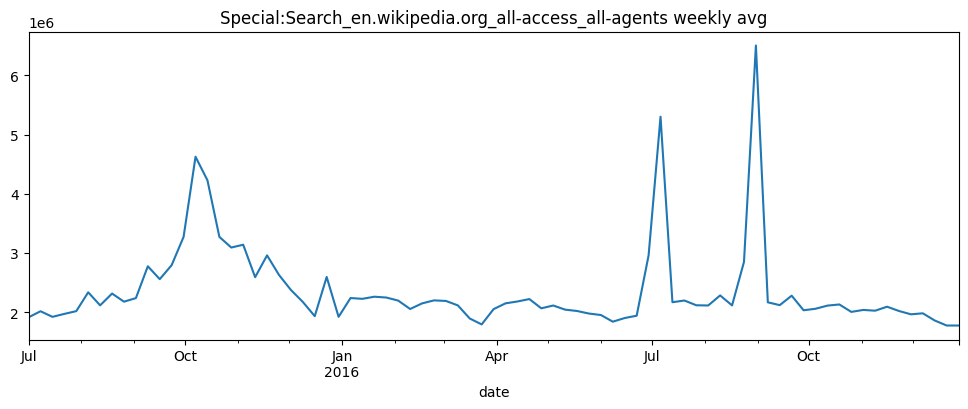

In [28]:
# sample pages by total views
agg = ts_en.groupby('page')['views'].sum().sort_values(ascending=False)
print(agg.head)
top_pages = agg.head(5).index.tolist()
print(top_pages)

# plot first top page
sample = top_pages[0]
s = ts_en[ts_en['page']==sample].set_index('date')['views'].sort_index()
s.plot(figsize=(12,4), title=sample)
plt.show()

# weekly seasonality detection (visual)
weekly = s.resample('7D').mean()
weekly.plot(figsize=(12,4), title=f"{sample} weekly avg")
plt.show()


# Language level partition

In [29]:
import gc
from collections import defaultdict

# Collect parquet files
parquet_files = sorted(glob.glob(OUT_DIR + "/*.parquet"))

# Dictionary: language -> list of pandas dataframes
lang_dfs = defaultdict(list)

# Dictionary: language -> row count
lang_counts = defaultdict(int)

for p in parquet_files:
    dfp = pl.read_parquet(p)

    # Get unique languages in this chunk
    languages = dfp.select("language").unique().to_series().to_list()

    for lang in languages:
        df_lang = dfp.filter(pl.col("language") == lang)

        if df_lang.height > 0:
            lang_counts[lang] += df_lang.height
            lang_dfs[lang].append(df_lang.to_pandas())

    del dfp, df_lang
    gc.collect()

# Combine and sort each language dataframe
final_ts = {}

for lang, dfs in lang_dfs.items():
    ts = pd.concat(dfs, ignore_index=True)
    ts["date"] = pd.to_datetime(ts["date"])
    ts = ts.sort_values(["page", "date"])
    final_ts[lang] = ts

# Print summary
print("\n Language-wise row counts:")
for lang, cnt in sorted(lang_counts.items(), key=lambda x: -x[1]):
    print(f"Language: {lang:5s} | Rows: {cnt:,}")



 Language-wise row counts:
Language: ja    | Rows: 9,946,750
Language: zh    | Rows: 8,353,950
Language: de    | Rows: 2,492,600
Language: es    | Rows: 1,910,150
Language: ru    | Rows: 1,599,950
Language: fr    | Rows: 1,408,550
Language: en    | Rows: 1,330,450


In [30]:
final_ts.keys()

dict_keys(['en', 'fr', 'zh', 'ru', 'ja', 'de', 'es'])

In [110]:
# Null percent on each language

In [31]:
overall_null_pct = {}

for lang, df in final_ts.items():
    total_cells = df.shape[0] * df.shape[1]
    total_nulls = df.isna().sum().sum()

    overall_null_pct[lang] = round((total_nulls / total_cells) * 100, 2)

overall_null_pct


{'en': np.float64(0.73),
 'fr': np.float64(0.19),
 'zh': np.float64(1.34),
 'ru': np.float64(0.19),
 'ja': np.float64(0.67),
 'de': np.float64(0.34),
 'es': np.float64(0.07)}

In [32]:
lang_dfs.items()

dict_items([('en', [                                                page      title language  \
0          !vote_en.wikipedia.org_desktop_all-agents      !vote       en   
1           1551_en.wikipedia.org_desktop_all-agents       1551       en   
2          AC/DC_en.wikipedia.org_desktop_all-agents      AC/DC       en   
3          AK-47_en.wikipedia.org_desktop_all-agents      AK-47       en   
4          AMGTV_en.wikipedia.org_desktop_all-agents      AMGTV       en   
...                                              ...        ...      ...   
85795       Nioh_en.wikipedia.org_desktop_all-agents       Nioh       en   
85796    Node.js_en.wikipedia.org_desktop_all-agents    Node.js       en   
85797     Nolito_en.wikipedia.org_desktop_all-agents     Nolito       en   
85798  Notepad++_en.wikipedia.org_desktop_all-agents  Notepad++       en   
85799     Nowruz_en.wikipedia.org_desktop_all-agents     Nowruz       en   

      access_type access_origin        date   views  
0         des

In [33]:
lang_dfs

defaultdict(list,
            {'en': [                                                page      title language  \
              0          !vote_en.wikipedia.org_desktop_all-agents      !vote       en   
              1           1551_en.wikipedia.org_desktop_all-agents       1551       en   
              2          AC/DC_en.wikipedia.org_desktop_all-agents      AC/DC       en   
              3          AK-47_en.wikipedia.org_desktop_all-agents      AK-47       en   
              4          AMGTV_en.wikipedia.org_desktop_all-agents      AMGTV       en   
              ...                                              ...        ...      ...   
              85795       Nioh_en.wikipedia.org_desktop_all-agents       Nioh       en   
              85796    Node.js_en.wikipedia.org_desktop_all-agents    Node.js       en   
              85797     Nolito_en.wikipedia.org_desktop_all-agents     Nolito       en   
              85798  Notepad++_en.wikipedia.org_desktop_all-agents  Notepad+

In [34]:
final_ts['en']

page    title language  \
624719  !vote_en.wikipedia.org_all-access_all-agents    !vote       en   
625438  !vote_en.wikipedia.org_all-access_all-agents    !vote       en   
626157  !vote_en.wikipedia.org_all-access_all-agents    !vote       en   
626876  !vote_en.wikipedia.org_all-access_all-agents    !vote       en   
627595  !vote_en.wikipedia.org_all-access_all-agents    !vote       en   
...                                              ...      ...      ...   
302819   d-block_en.wikipedia.org_desktop_all-agents  d-block       en   
303217   d-block_en.wikipedia.org_desktop_all-agents  d-block       en   
303615   d-block_en.wikipedia.org_desktop_all-agents  d-block       en   
304013   d-block_en.wikipedia.org_desktop_all-agents  d-block       en   
304411   d-block_en.wikipedia.org_desktop_all-agents  d-block       en   

       access_type access_origin       date  views  
624719  all-access    all-agents 2015-07-01    3.0  
625438  all-access    all-agents 2015-07-02    4.0  
626157  all-access    all-agents 2015-07-03    7.0  
626876  all-access    all-agents 2015-07-04    4.0  
627595  all-access    all-agents 2015-07-05    4.0  
...            ...           ...        ...    ...  
302819     desktop    all-agents 2016-12-27    8.0  
303217     desktop    all-agents 2016-12-28    4.0  
303615     desktop    all-agents 2016-12-29    9.0  
304013     desktop    all-agents 2016-12-30    2.0  
304411     desktop    all-agents 2016-12-31    3.0  

[1330450 rows x 7 columns]

In [35]:
lang_dfs.keys()

dict_keys(['en', 'fr', 'zh', 'ru', 'ja', 'de', 'es'])

In [116]:
#

#Analyze language top pages

In [36]:
#Analyze language top pages
def analyze_language_pages(
    lang: str,
    dfs: list[pd.DataFrame],
    top_n: int = 5,
    freq: str = "7D",
    plot: bool = True,
):
    """
    Analyze top pages for a single language:
    - Aggregate views
    - Plot daily trend
    - Plot weekly seasonality

    Memory-efficient: processes only ONE language at a time.
    """

    print(f"\n===== Language: {lang} =====")

    # Concatenate only this language
    ts = pd.concat(dfs, ignore_index=True)[['page', 'date', 'views']]
    ts['date'] = pd.to_datetime(ts['date'])

    # Top pages by total views
    agg = (
        ts.groupby('page')['views']
        .sum()
        .sort_values(ascending=False)
    )

    top_pages = agg.head(top_n).index.tolist()
    print("Top pages:", top_pages)

    # Process ONE page at a time
    for page in top_pages:
        s = (
            ts[ts['page'] == page]
            .set_index('date')['views']
            .sort_index()
        )

        if plot:
            # Daily
            s.plot(figsize=(12,4), title=f"{lang} | {page} daily")
            plt.show()

            # Weekly seasonality
            weekly = s.resample(freq).mean()
            weekly.plot(figsize=(12,4), title=f"{lang} | {page} weekly avg")
            plt.show()

    # Explicit cleanup (safe for large data)
    del ts



===== Language: en =====
Top pages: ['Special:Search_en.wikipedia.org_all-access_all-agents', 'Special:Search_en.wikipedia.org_desktop_all-agents', 'Special:Search_en.wikipedia.org_mobile-web_all-agents', 'Special:Book_en.wikipedia.org_all-access_all-agents', 'Special:Book_en.wikipedia.org_desktop_all-agents']


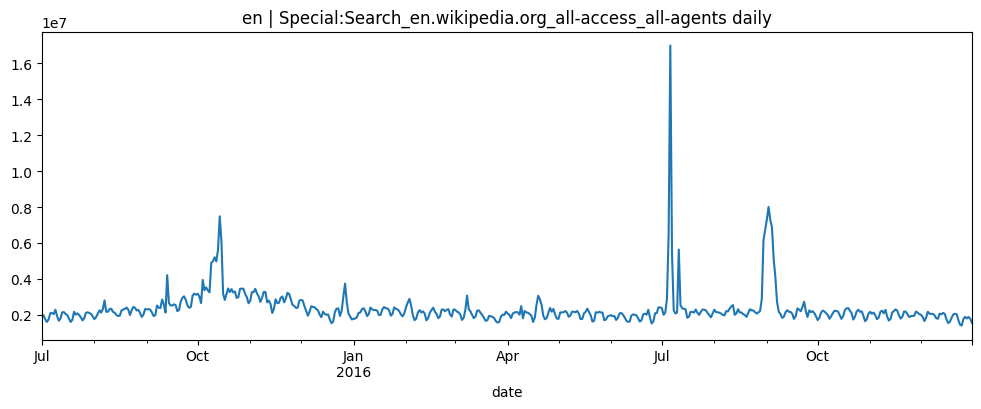

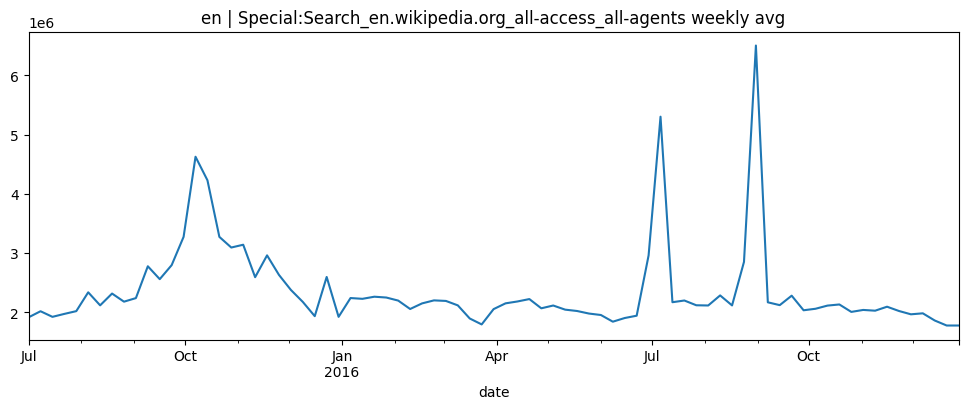

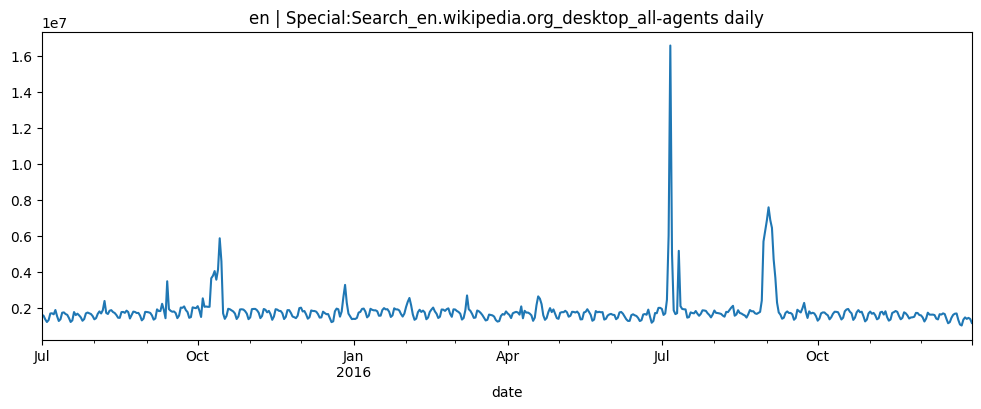

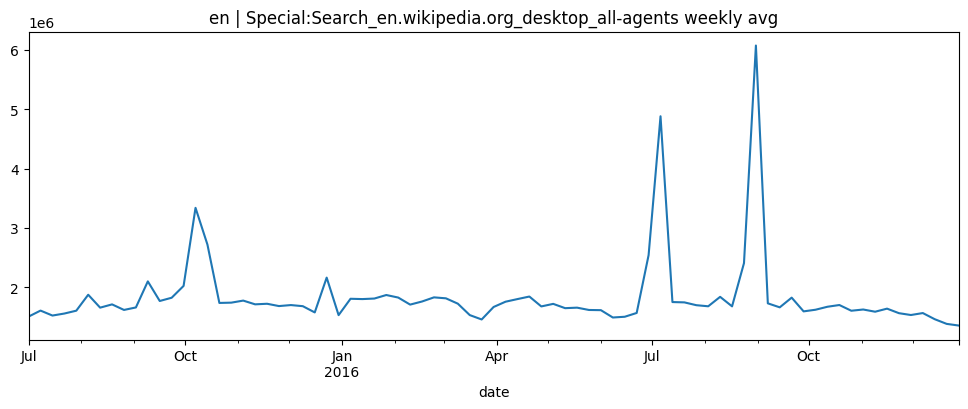

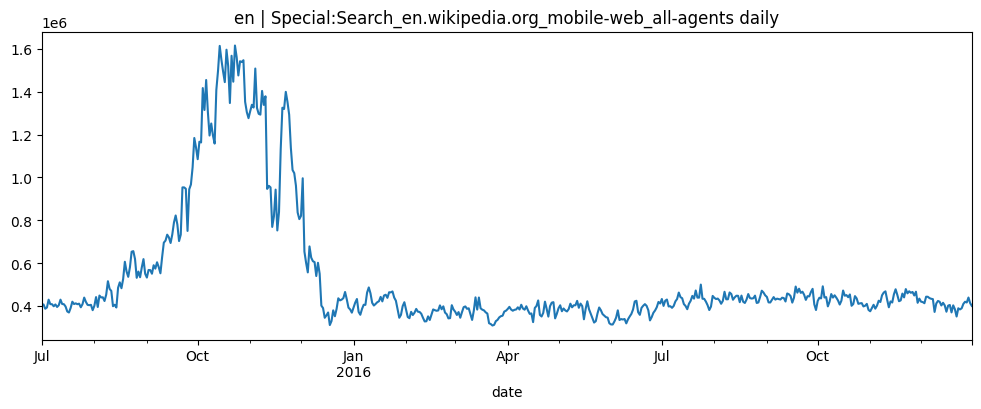

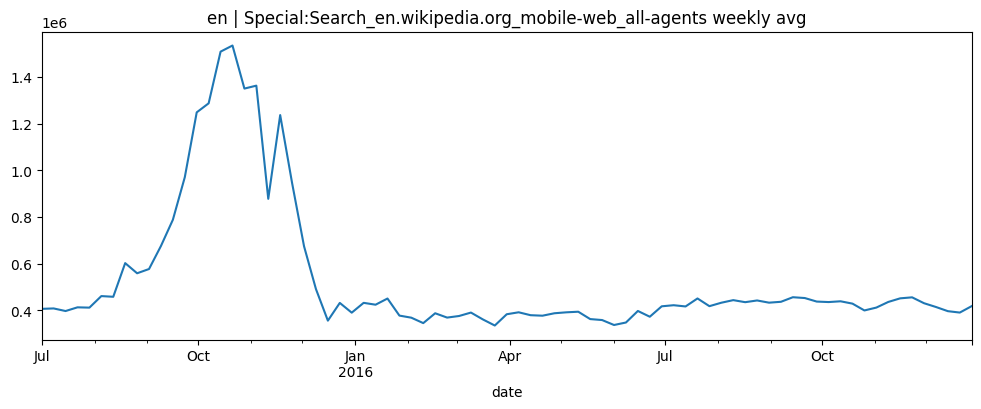

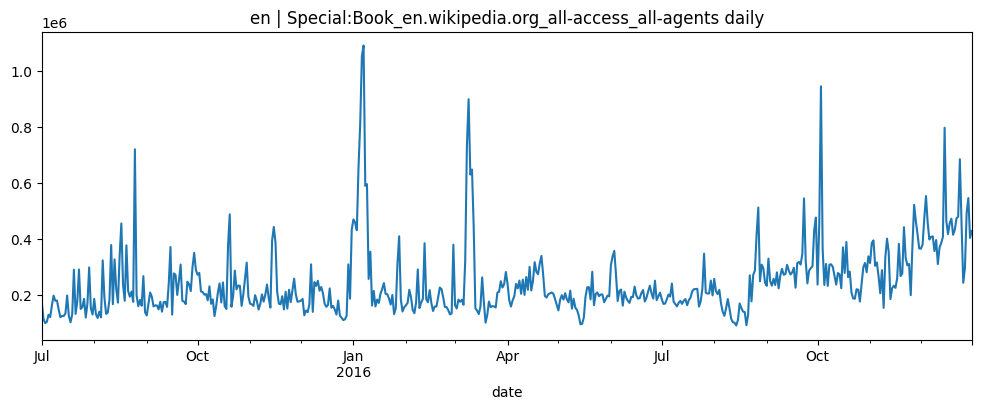

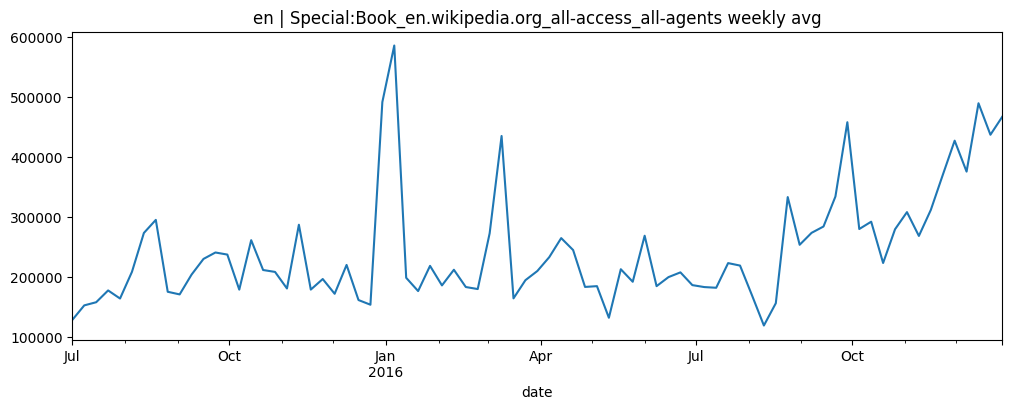

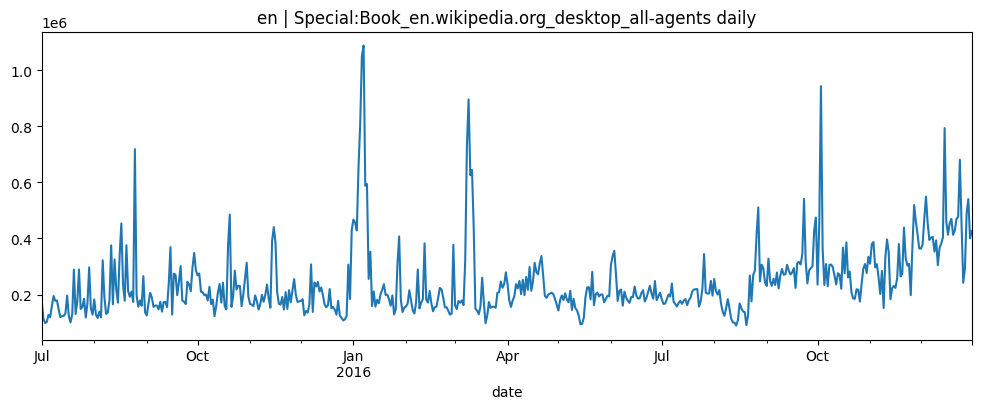

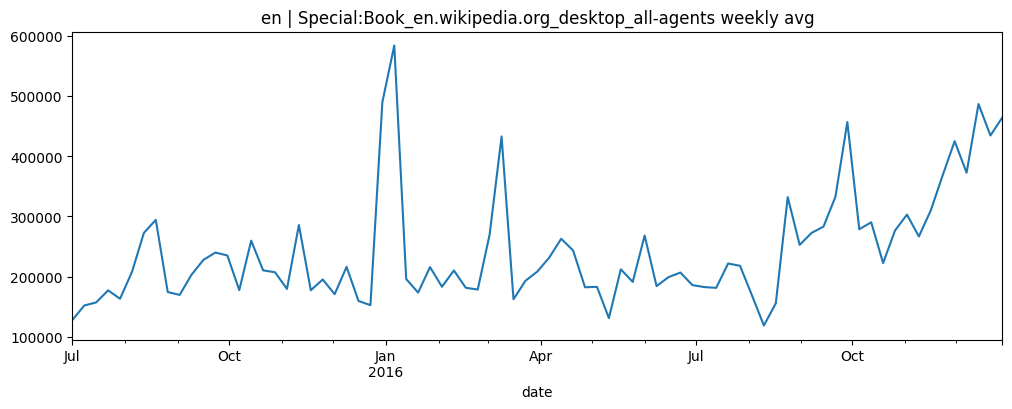


===== Language: fr =====
Top pages: ['Spécial:Recherche_fr.wikipedia.org_all-access_all-agents', 'Spécial:Recherche_fr.wikipedia.org_desktop_all-agents', 'Sp?cial:Search_fr.wikipedia.org_all-access_all-agents', 'Sp?cial:Search_fr.wikipedia.org_desktop_all-agents', 'Spécial:Connexion_fr.wikipedia.org_all-access_all-agents']


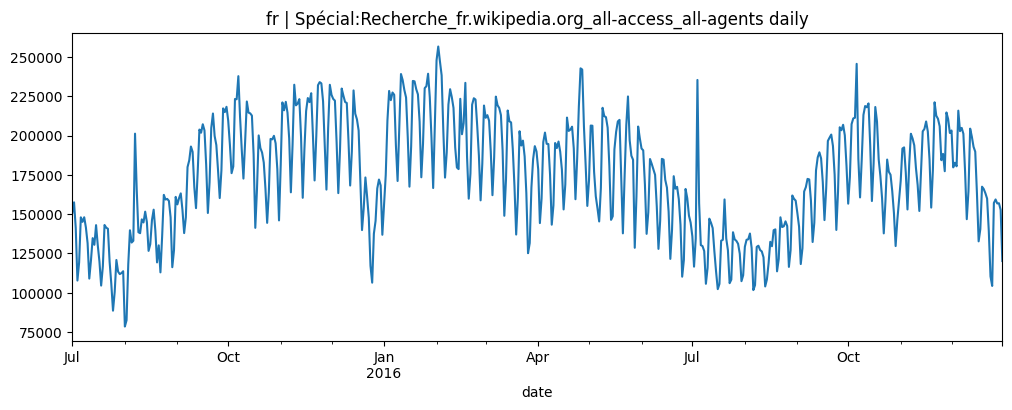

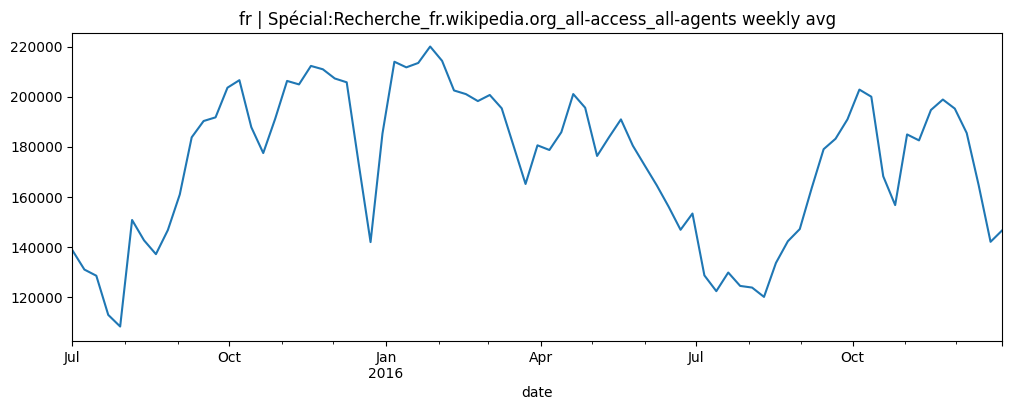

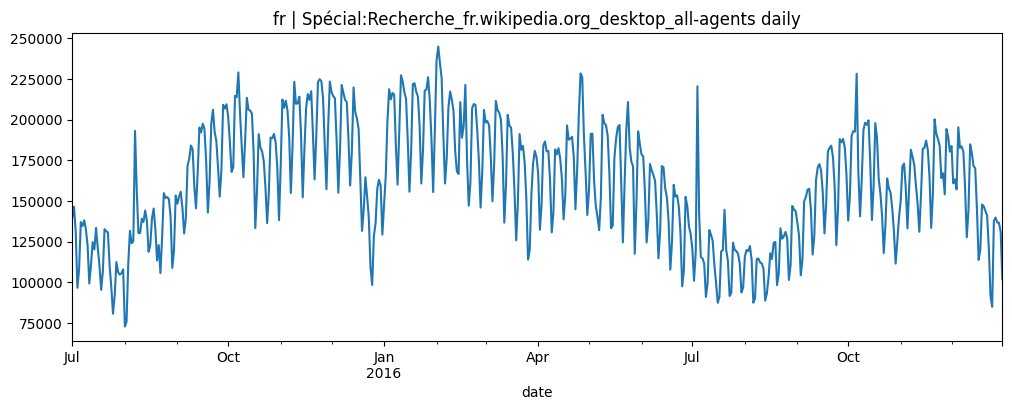

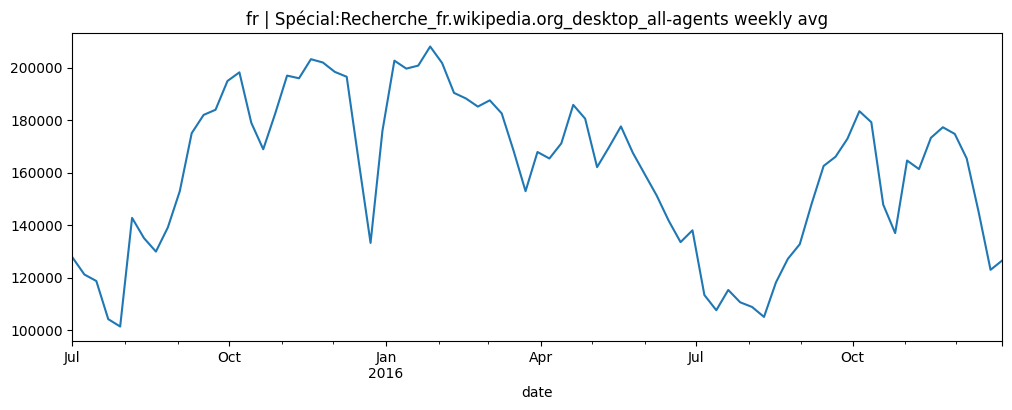

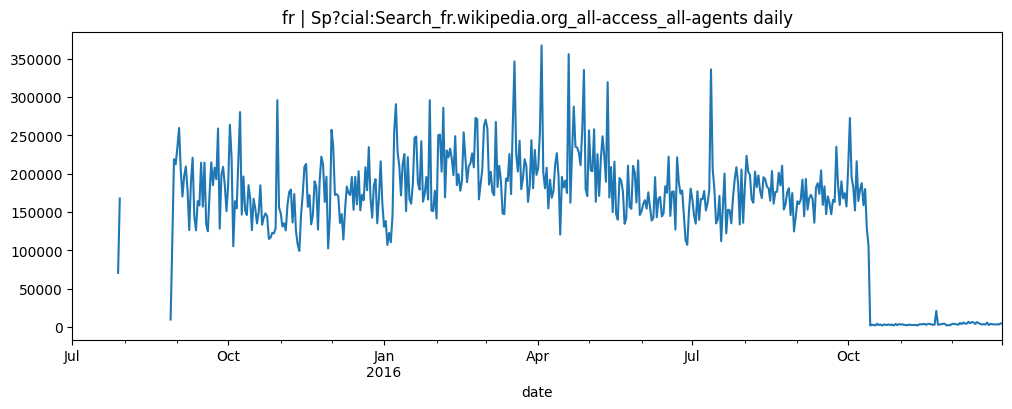

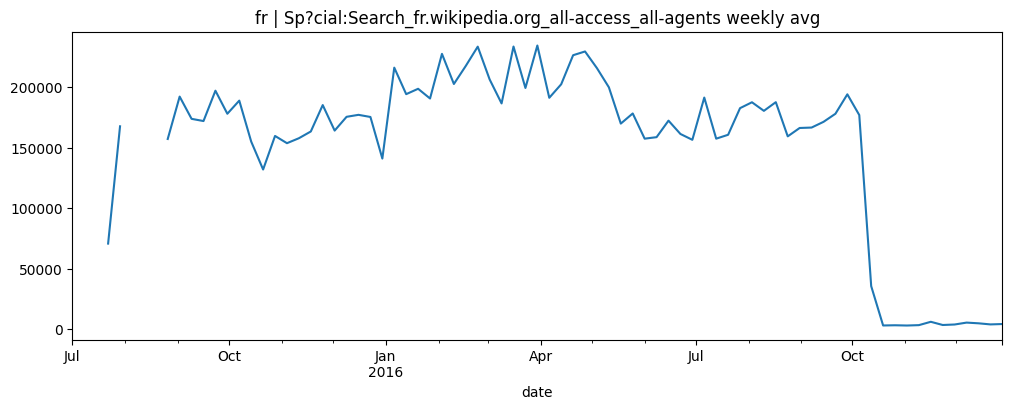

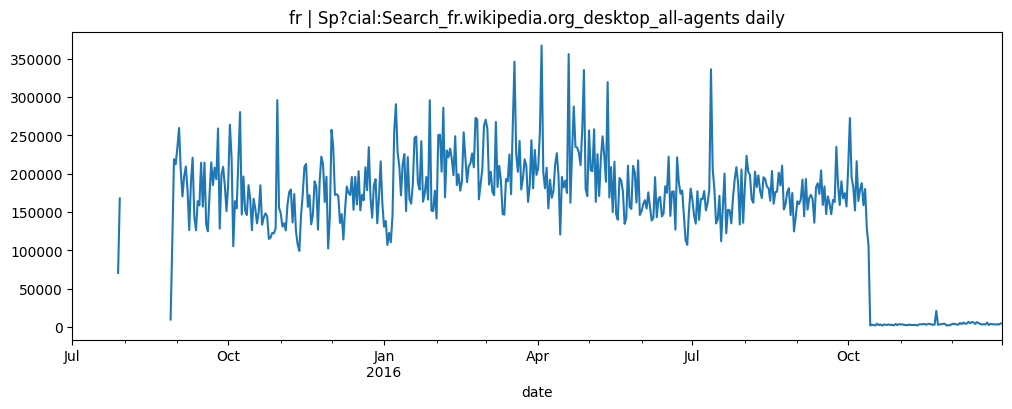

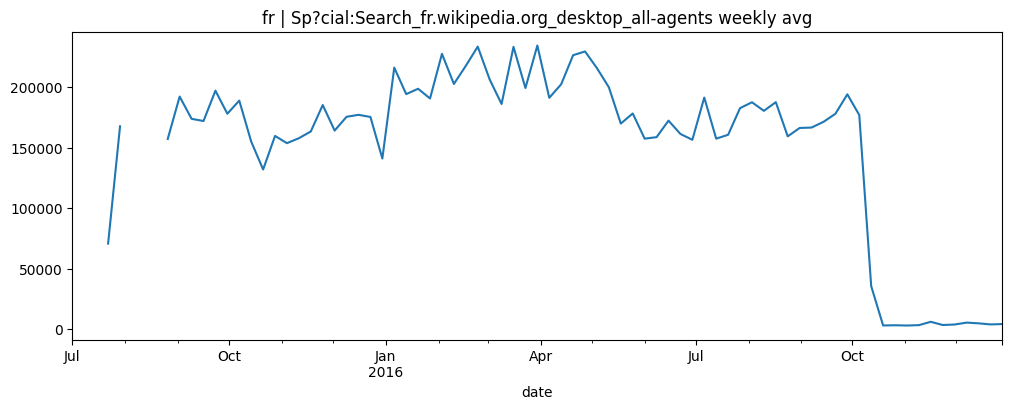

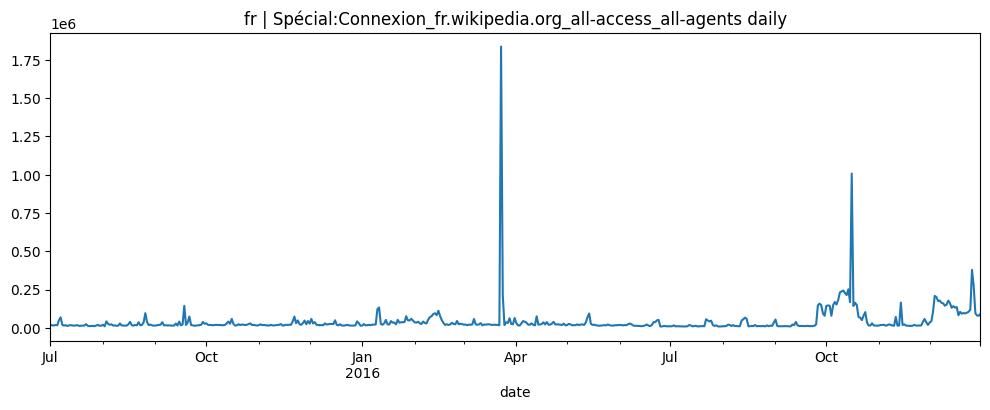

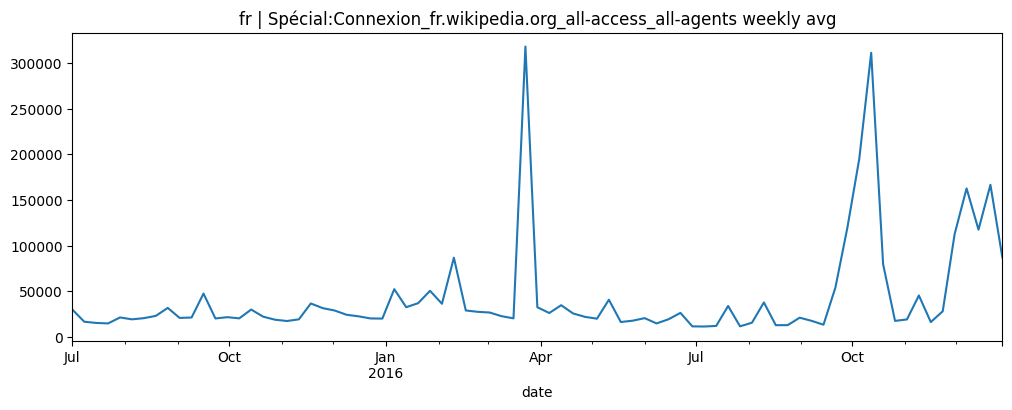


===== Language: zh =====
Top pages: ['Wikipedia:首页_zh.wikipedia.org_all-access_all-agents', 'Wikipedia:首页_zh.wikipedia.org_desktop_all-agents', 'Wikipedia:首页_zh.wikipedia.org_mobile-web_all-agents', 'Special:搜索_zh.wikipedia.org_all-access_all-agents', 'Special:搜索_zh.wikipedia.org_desktop_all-agents']


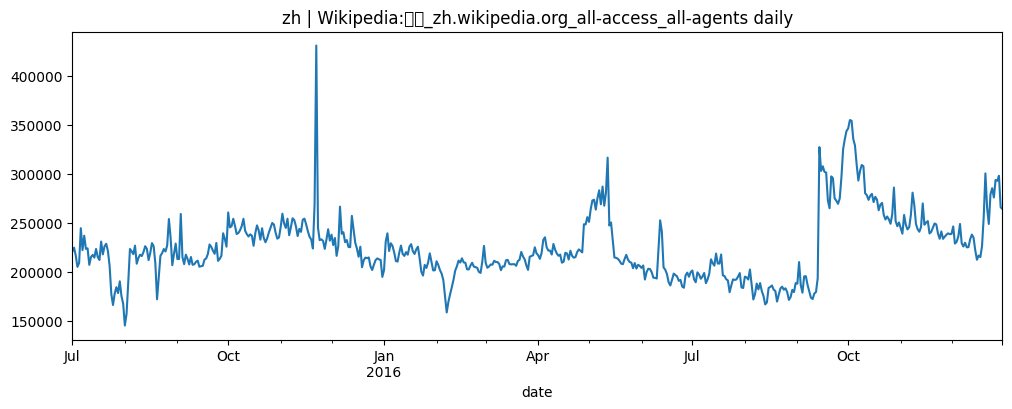

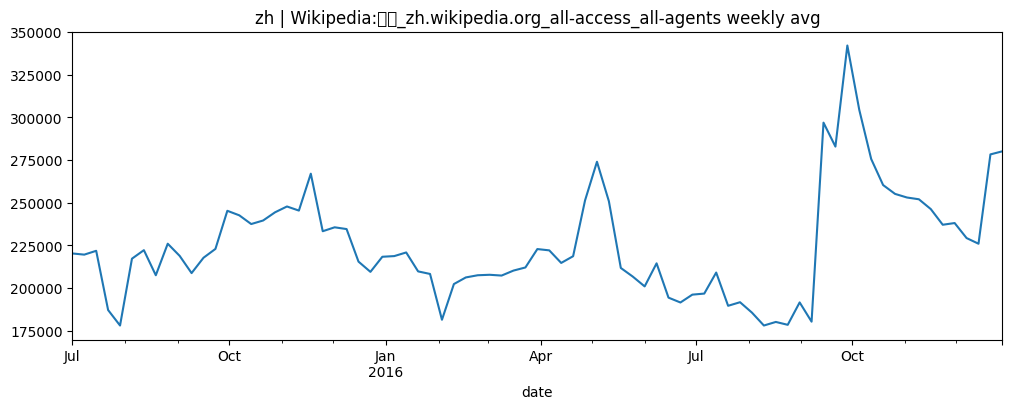

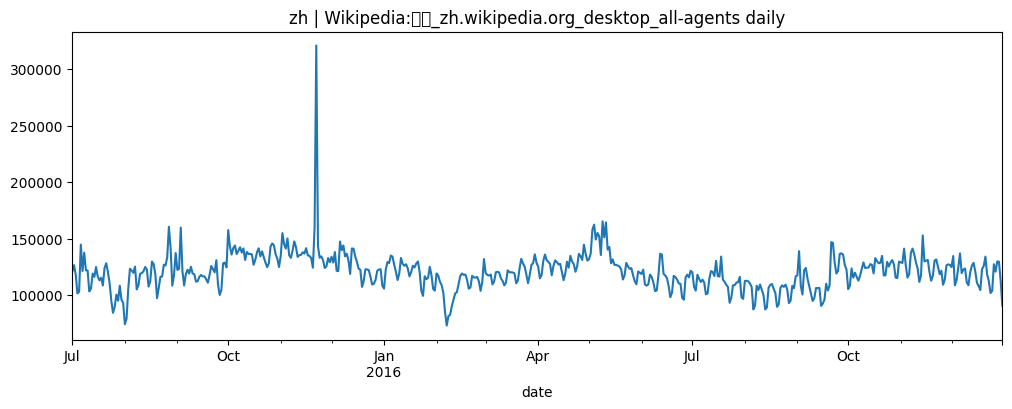

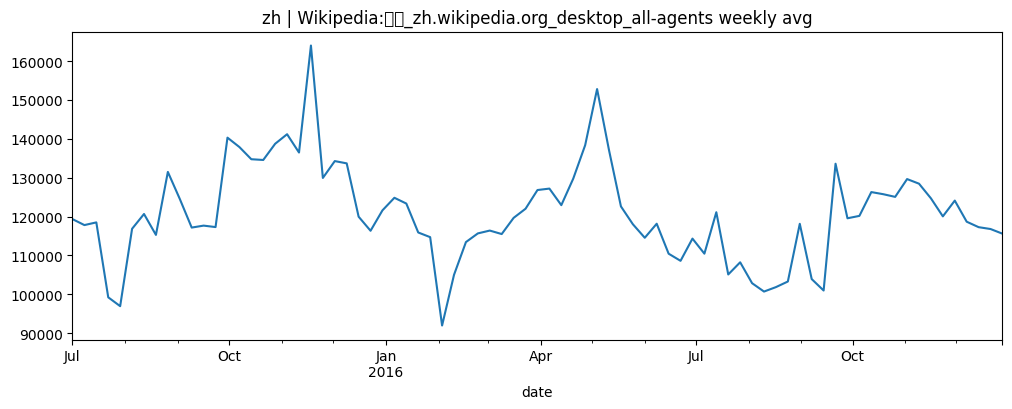

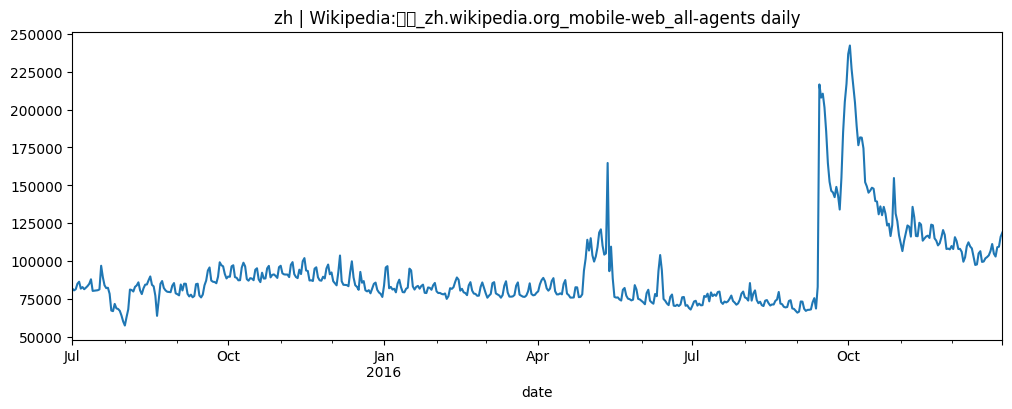

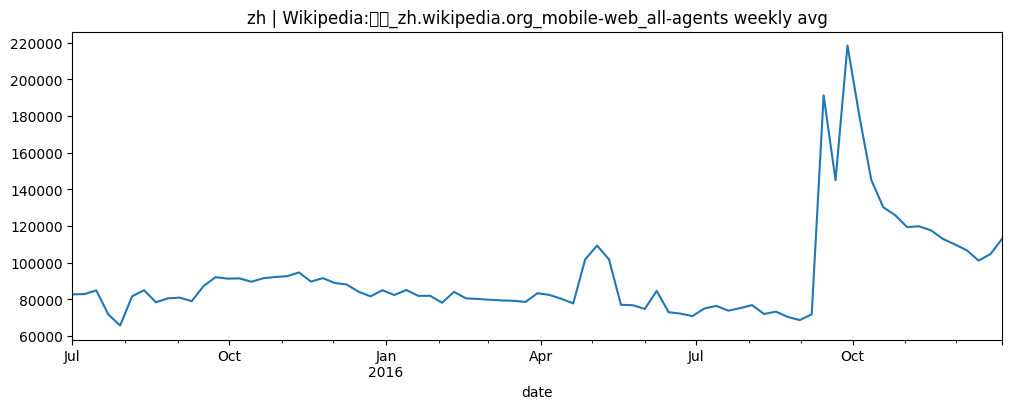

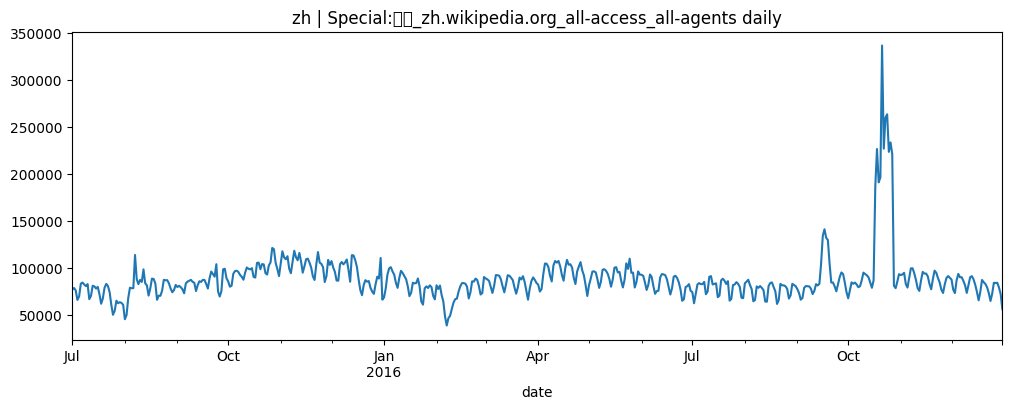

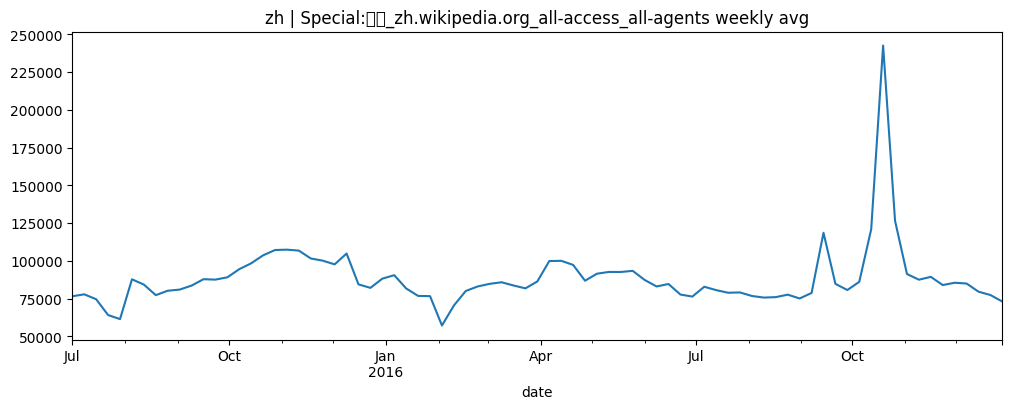

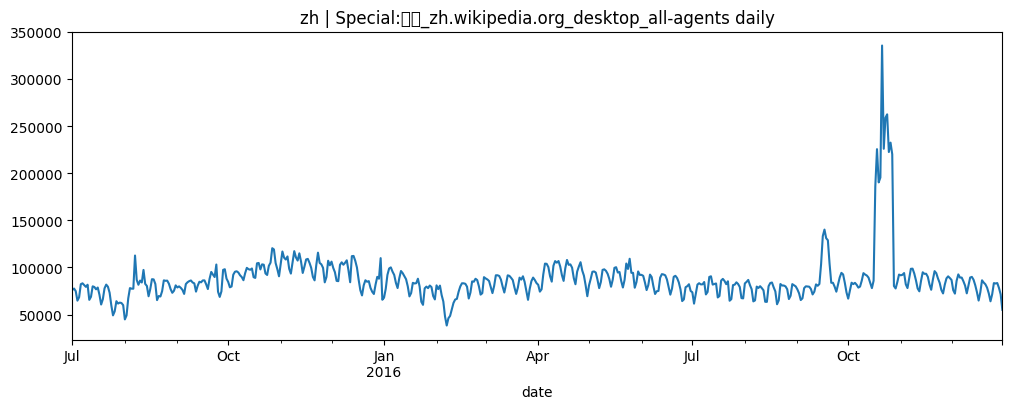

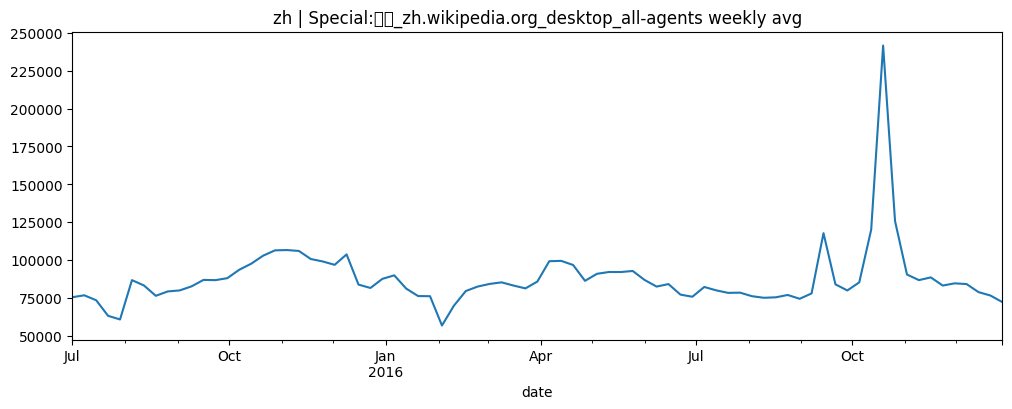


===== Language: ru =====
Top pages: ['Служебная:Поиск_ru.wikipedia.org_all-access_all-agents', 'Служебная:Поиск_ru.wikipedia.org_desktop_all-agents', 'Special:Search_ru.wikipedia.org_all-access_all-agents', 'Special:Search_ru.wikipedia.org_desktop_all-agents', 'Служебная:Вход_ru.wikipedia.org_all-access_all-agents']


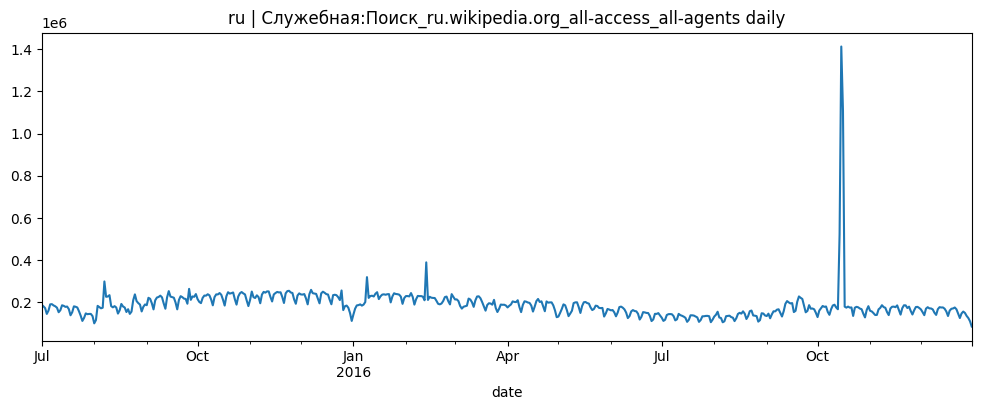

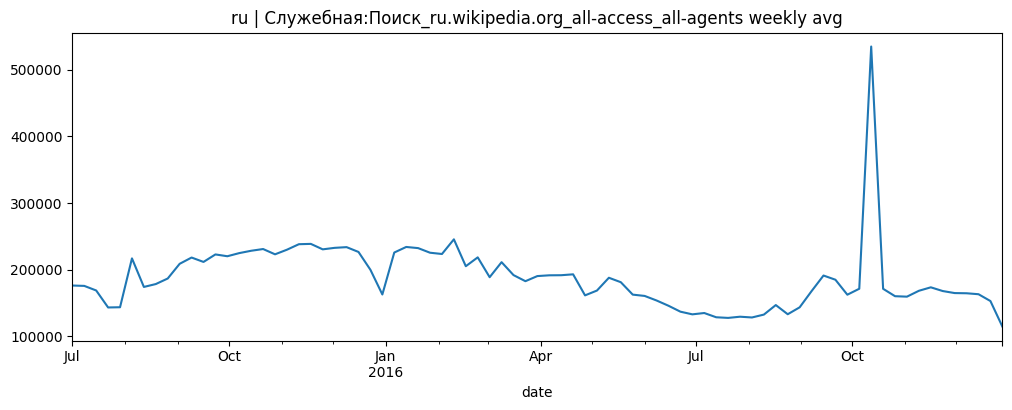

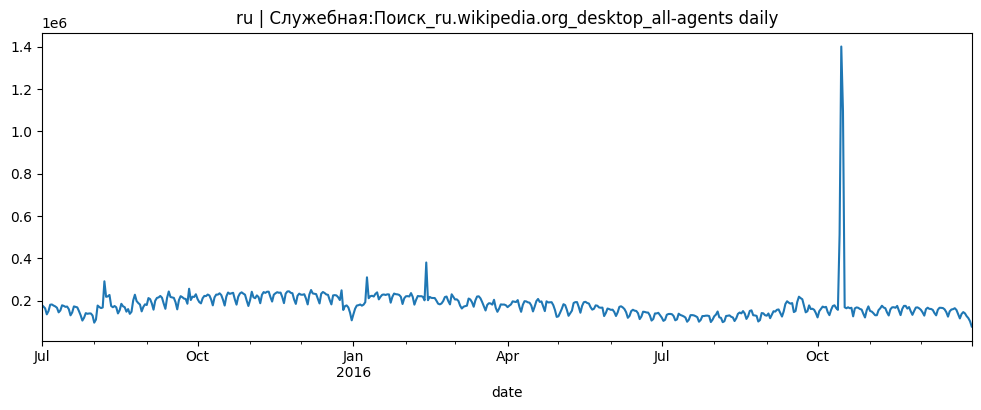

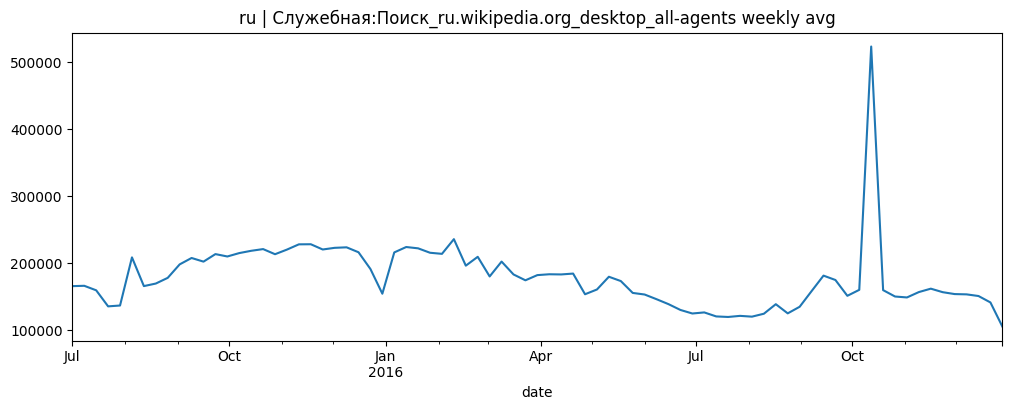

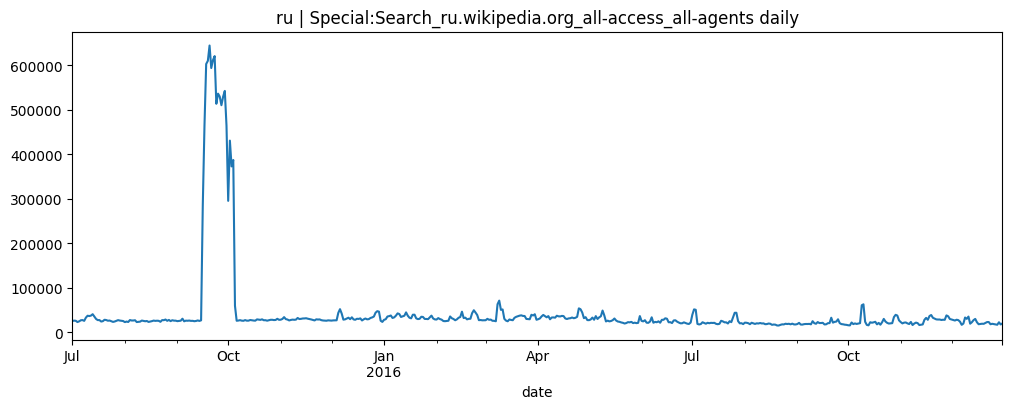

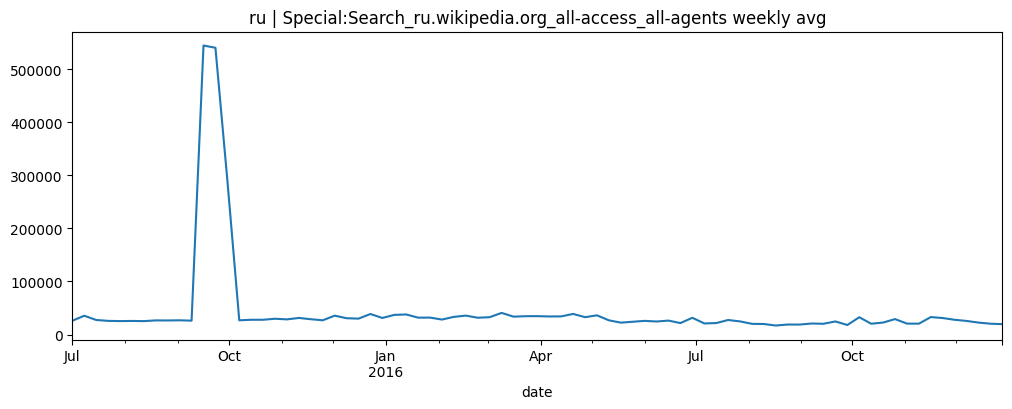

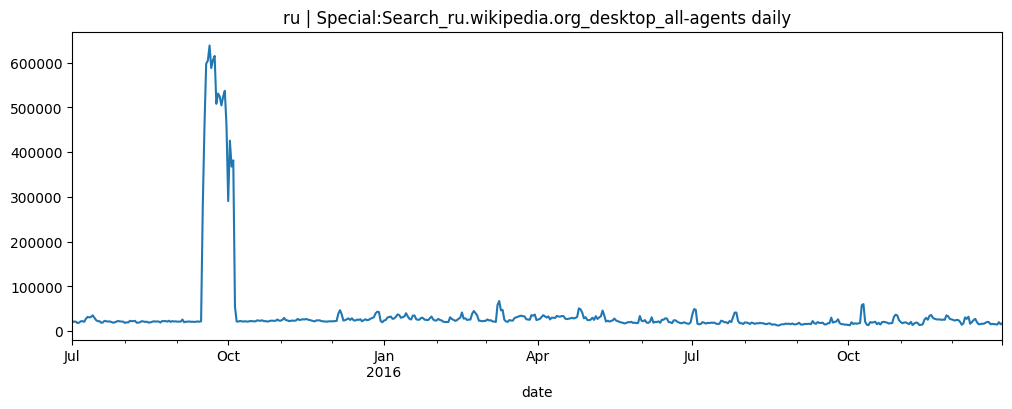

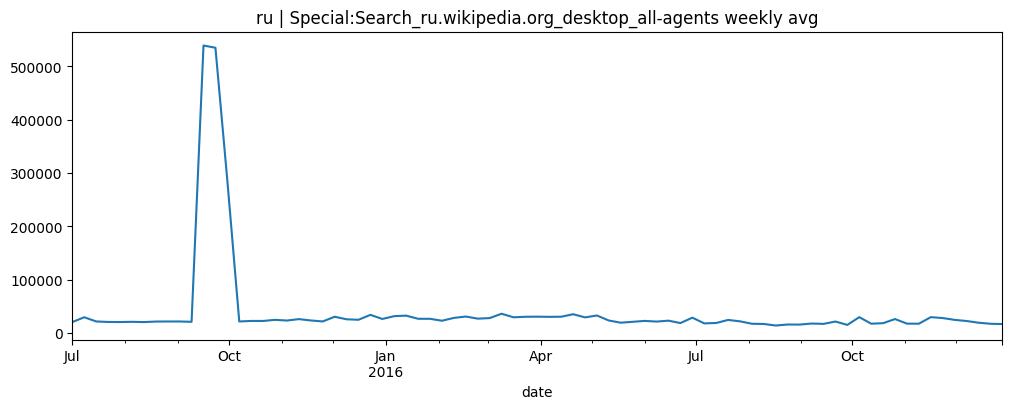

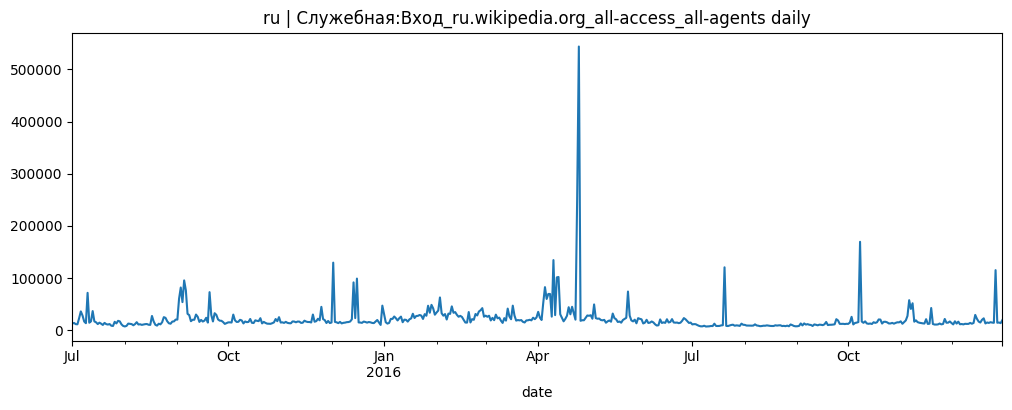

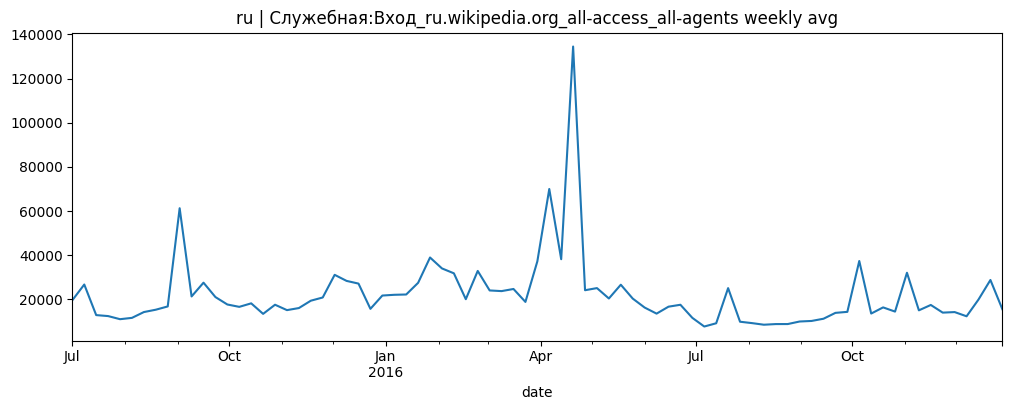


===== Language: ja =====
Top pages: ['メインページ_ja.wikipedia.org_all-access_all-agents', 'メインページ_ja.wikipedia.org_desktop_all-agents', '特別:検索_ja.wikipedia.org_all-access_all-agents', '特別:検索_ja.wikipedia.org_desktop_all-agents', 'メインページ_ja.wikipedia.org_mobile-web_all-agents']


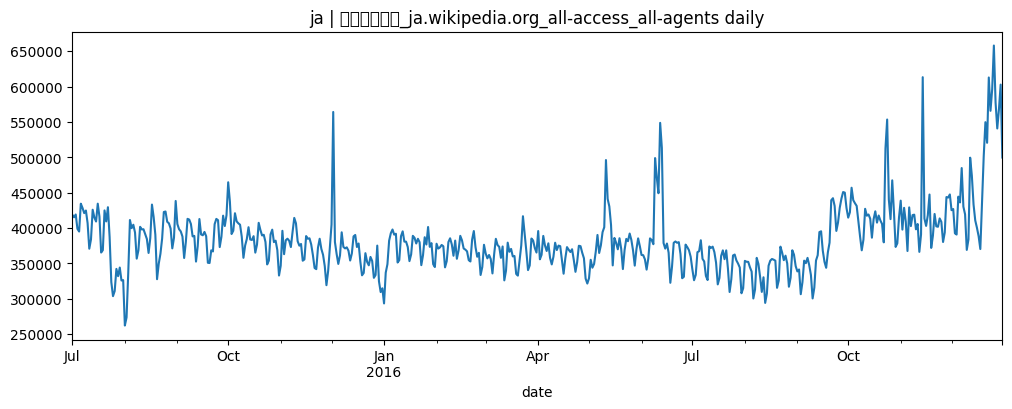

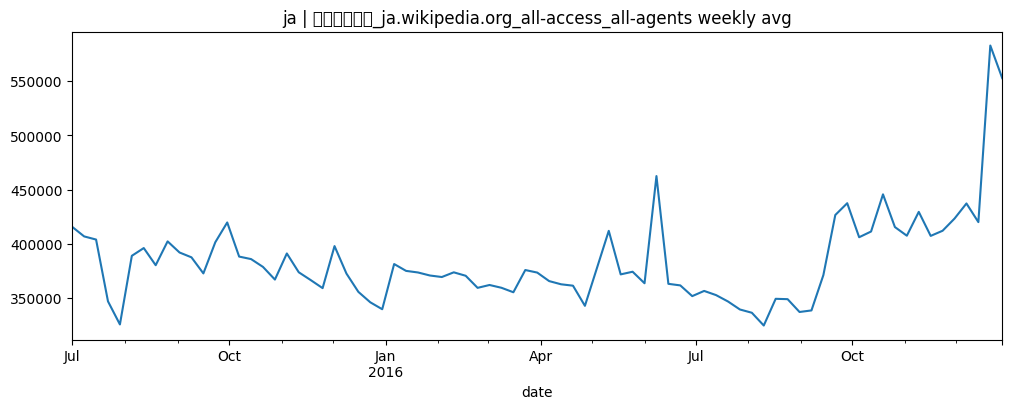

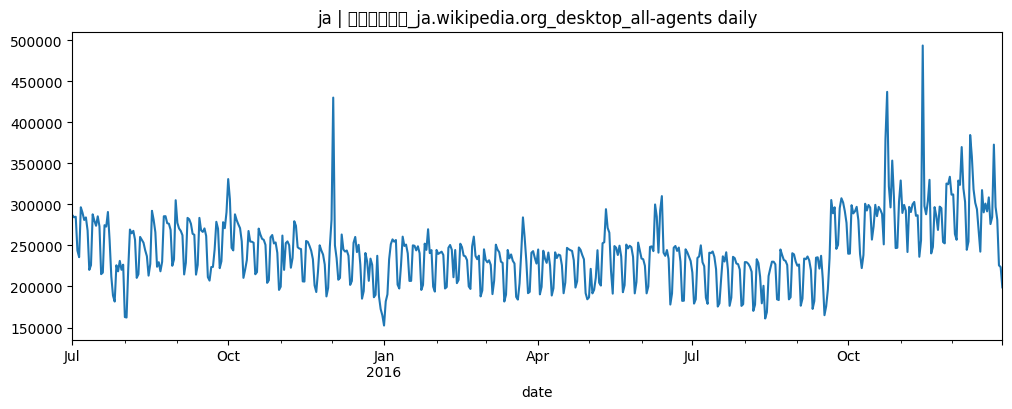

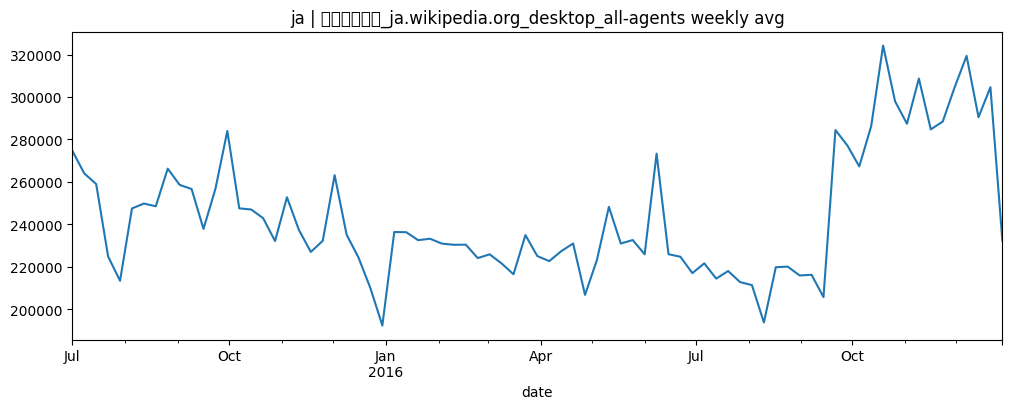

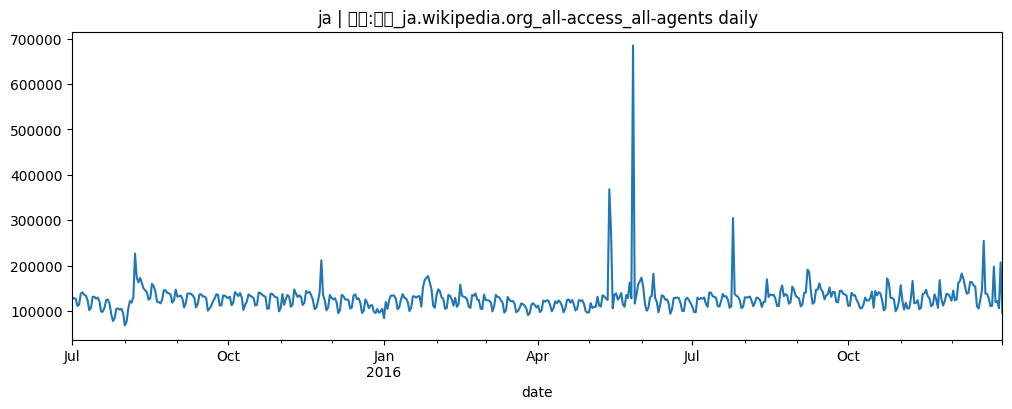

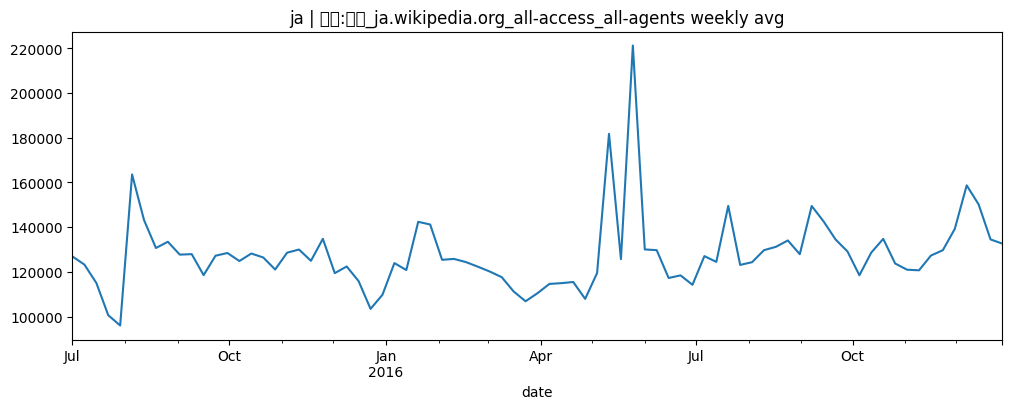

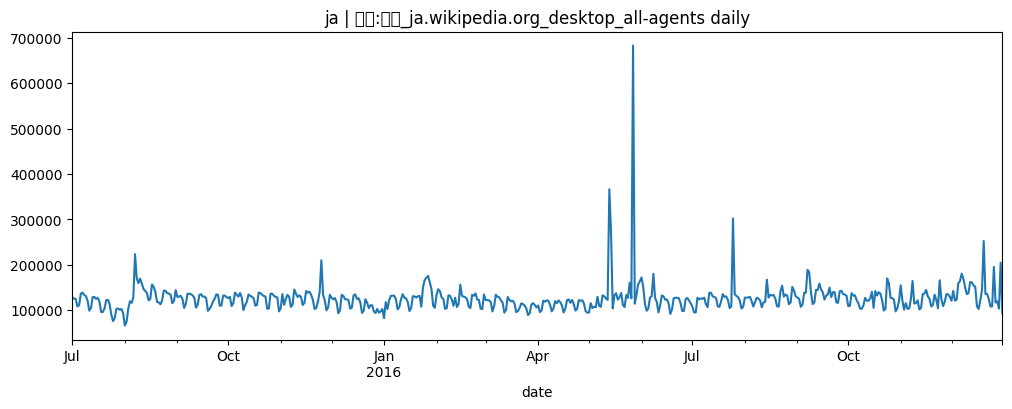

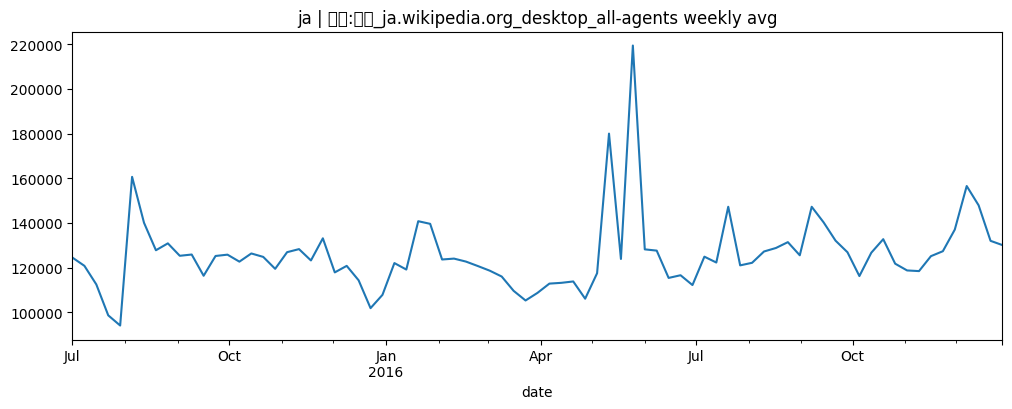

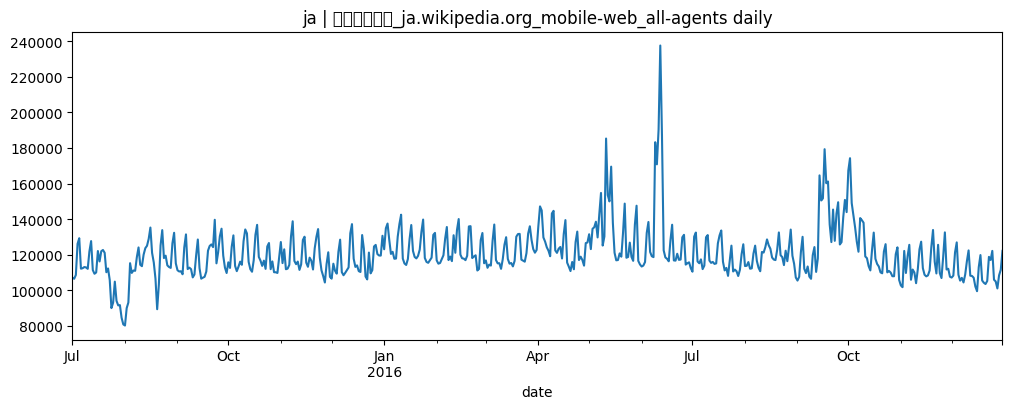

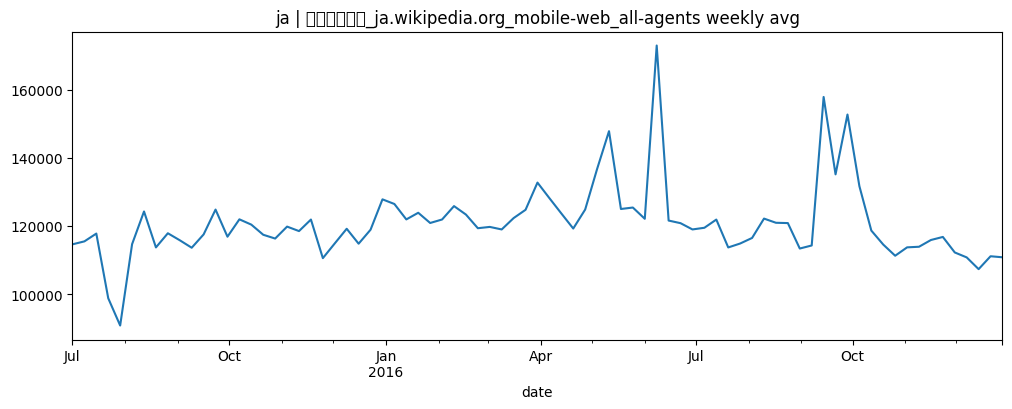


===== Language: de =====
Top pages: ['Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents', 'Wikipedia:Hauptseite_de.wikipedia.org_mobile-web_all-agents', 'Wikipedia:Hauptseite_de.wikipedia.org_desktop_all-agents', 'Spezial:Suche_de.wikipedia.org_all-access_all-agents', 'Spezial:Suche_de.wikipedia.org_desktop_all-agents']


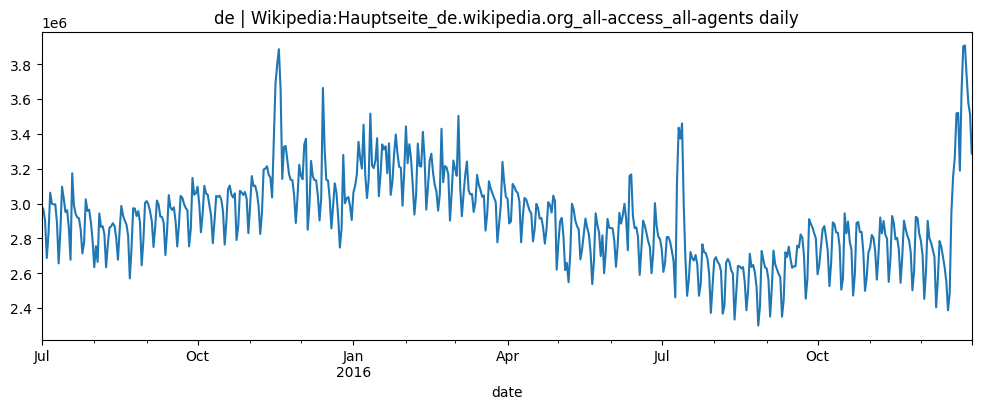

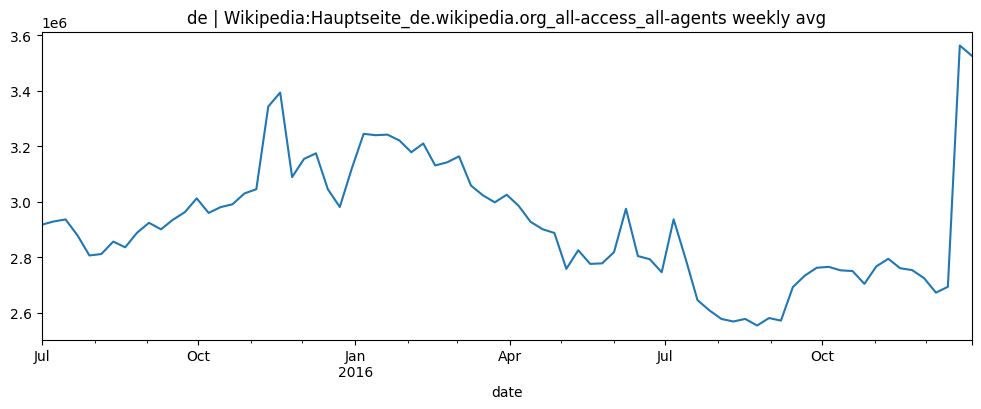

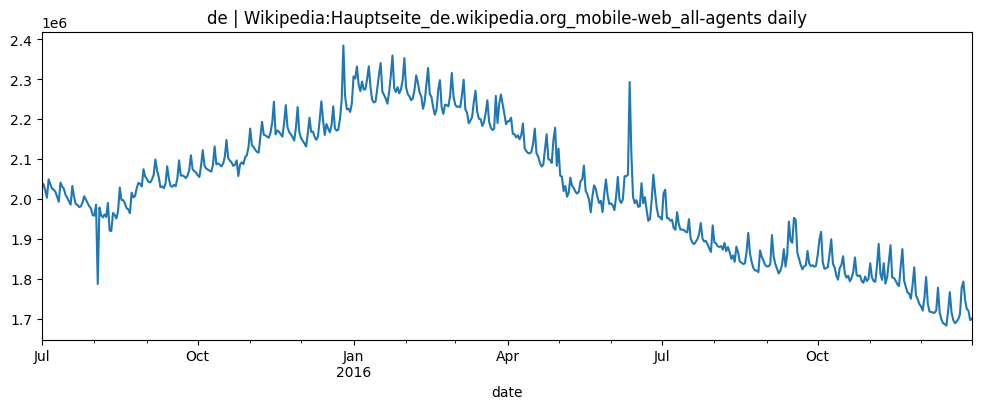

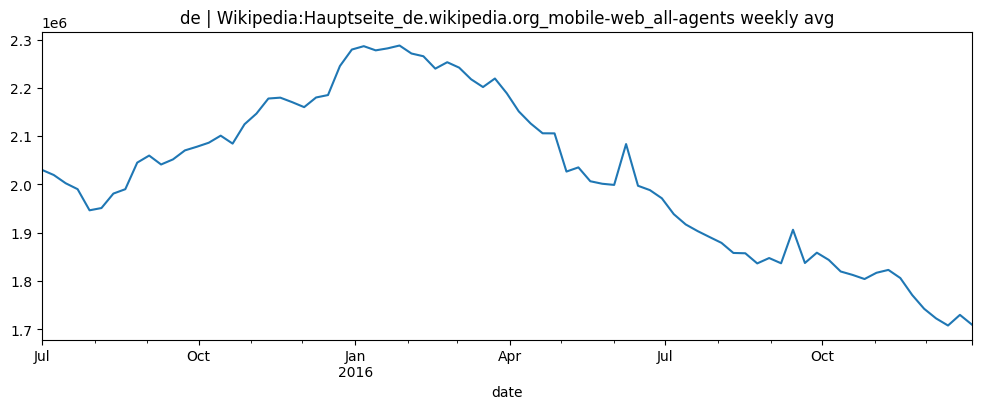

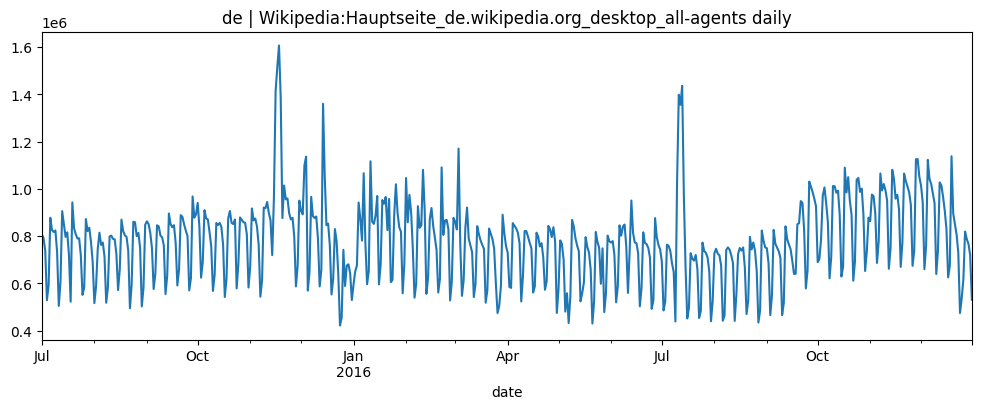

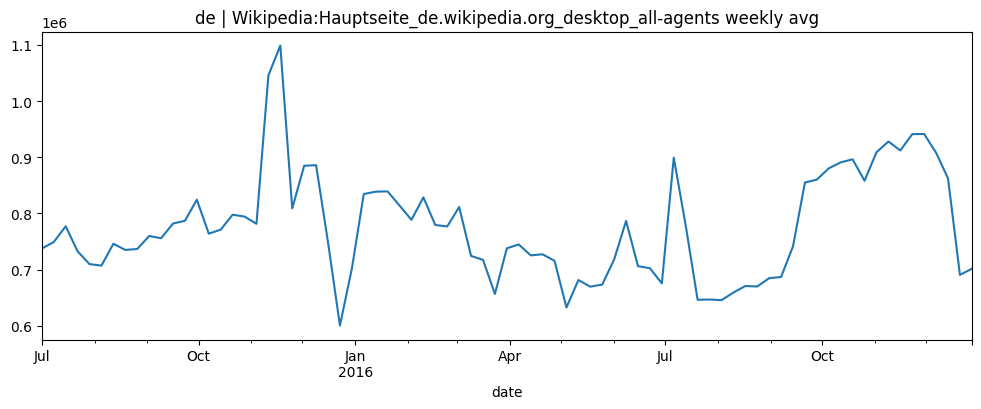

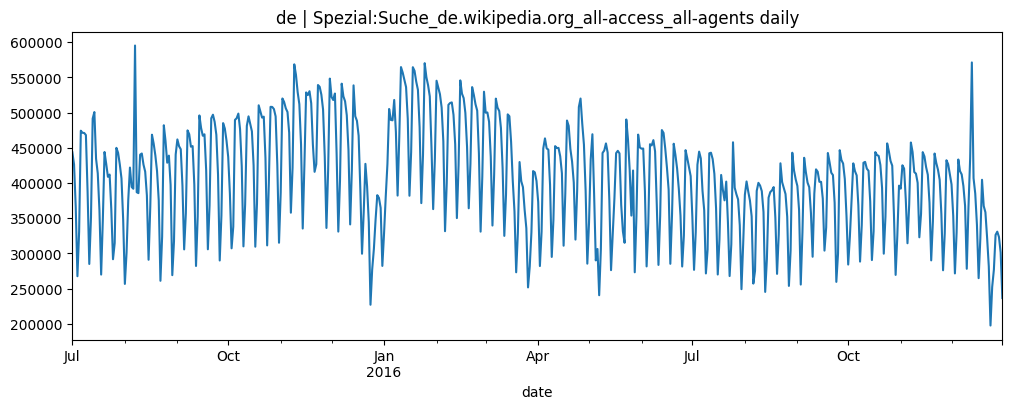

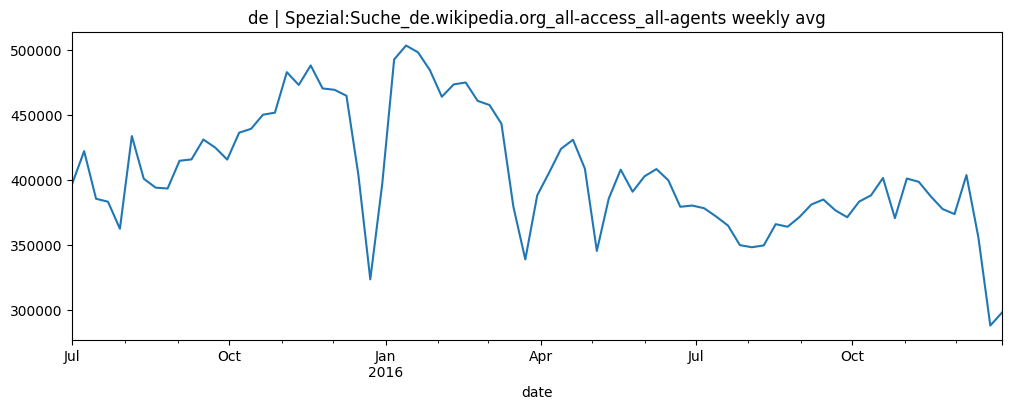

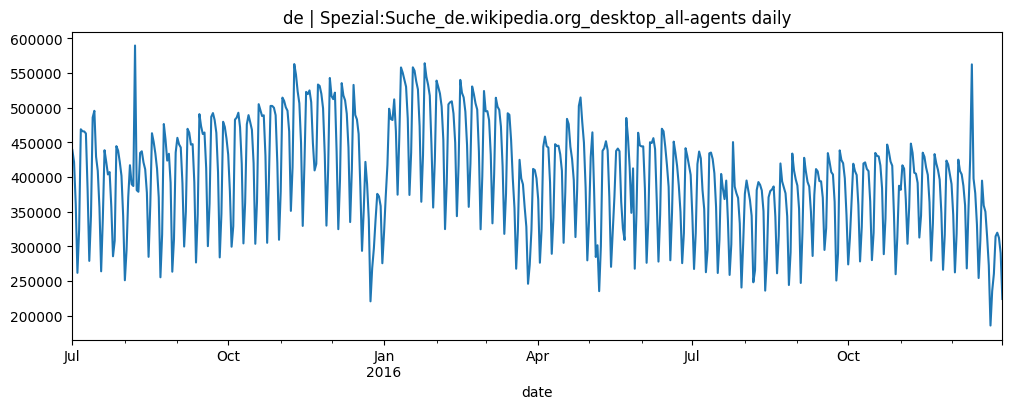

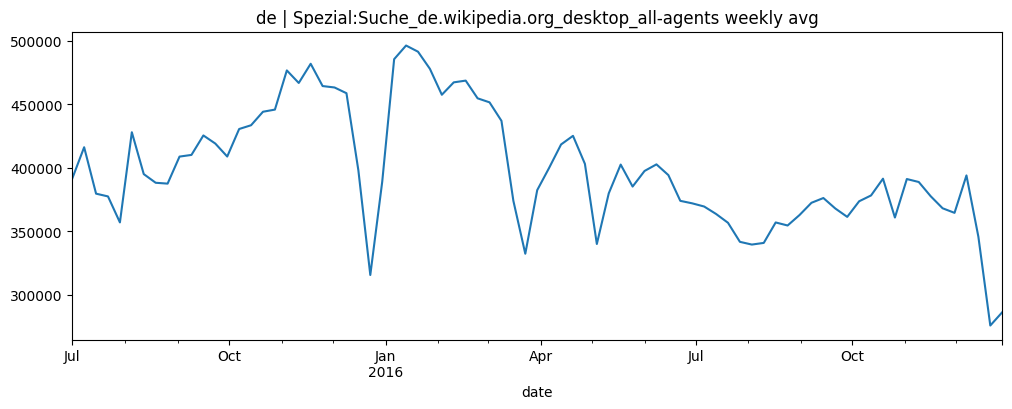


===== Language: es =====
Top pages: ['Wikipedia:Portada_es.wikipedia.org_all-access_all-agents', 'Wikipedia:Portada_es.wikipedia.org_mobile-web_all-agents', 'Especial:Buscar_es.wikipedia.org_all-access_all-agents', 'Wikipedia:Portada_es.wikipedia.org_desktop_all-agents', 'Especial:Buscar_es.wikipedia.org_desktop_all-agents']


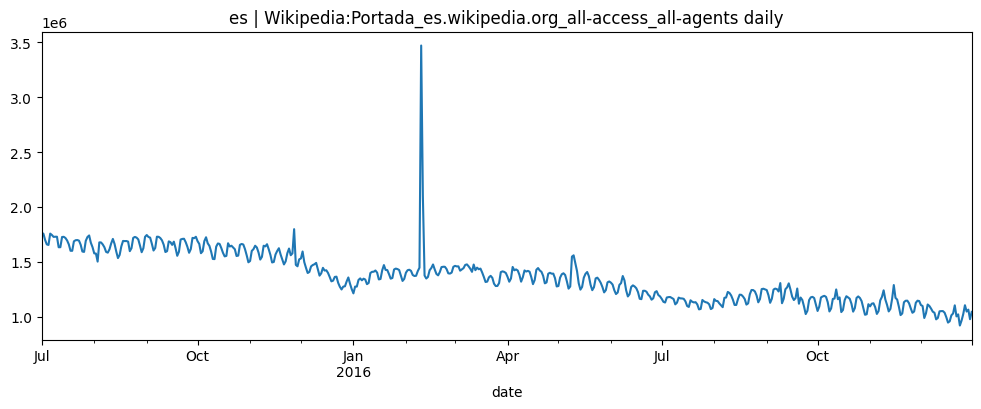

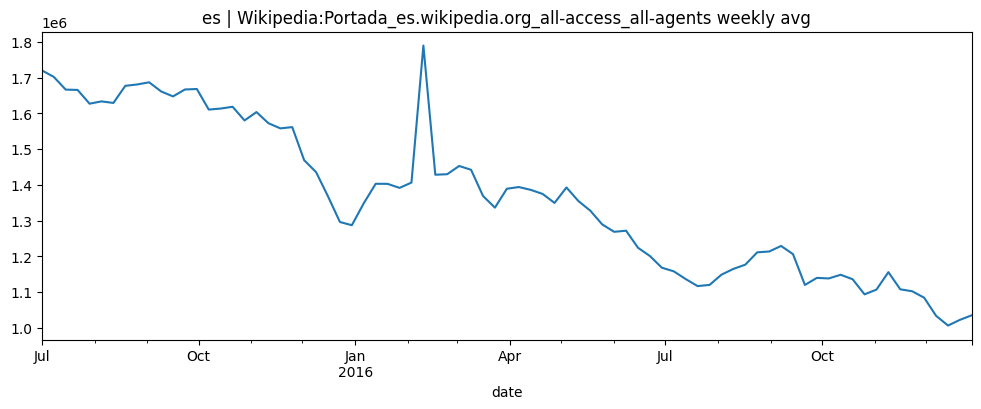

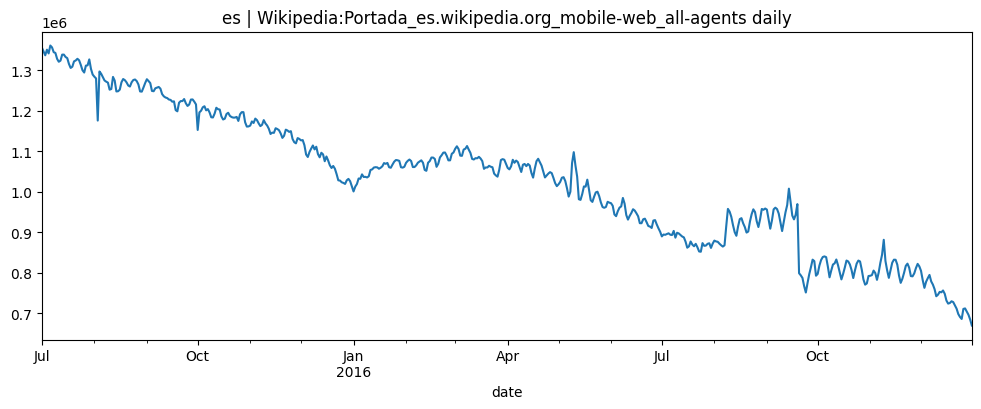

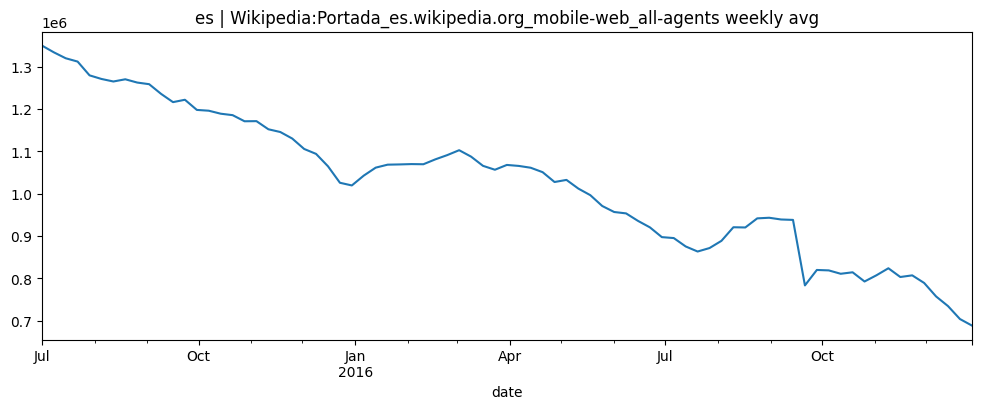

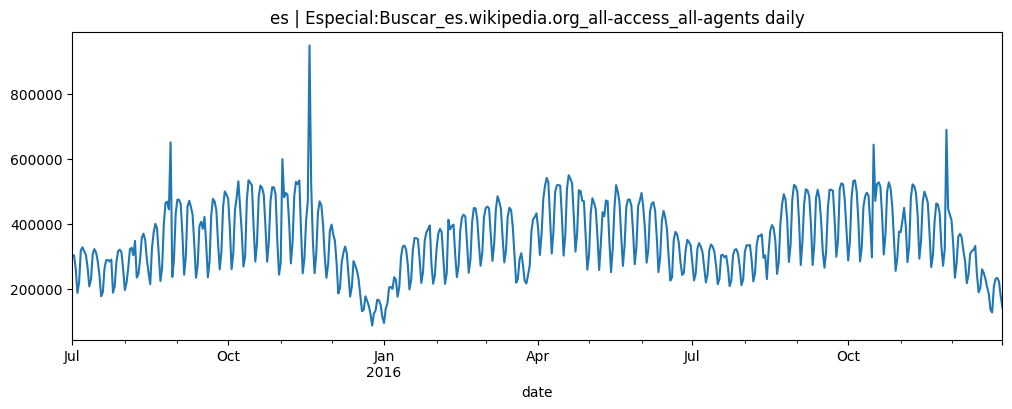

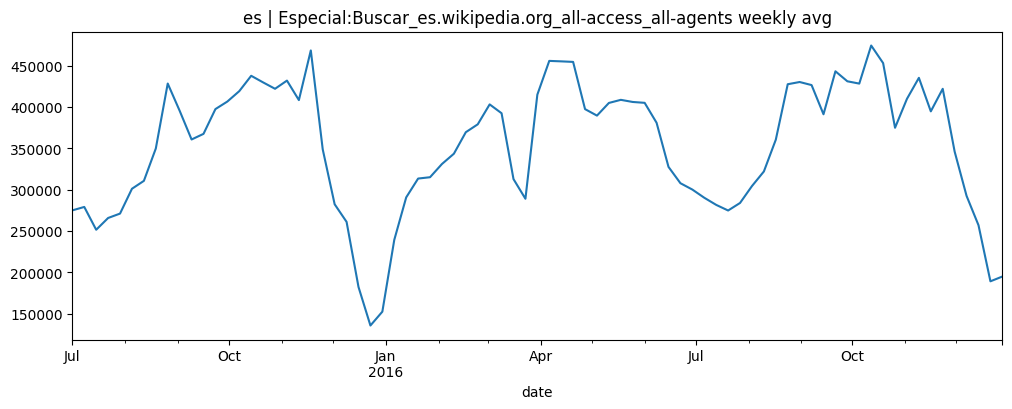

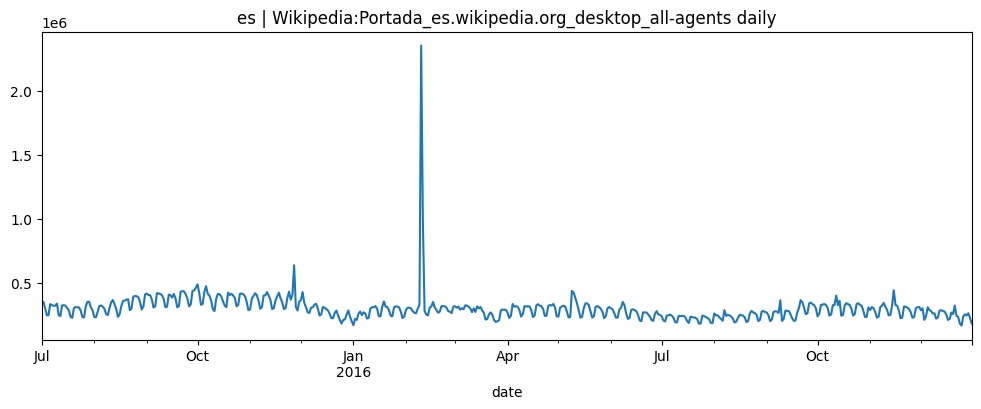

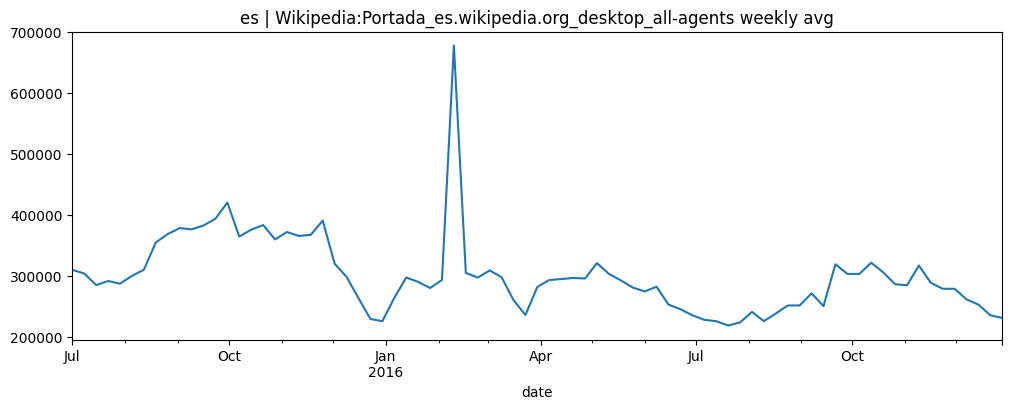

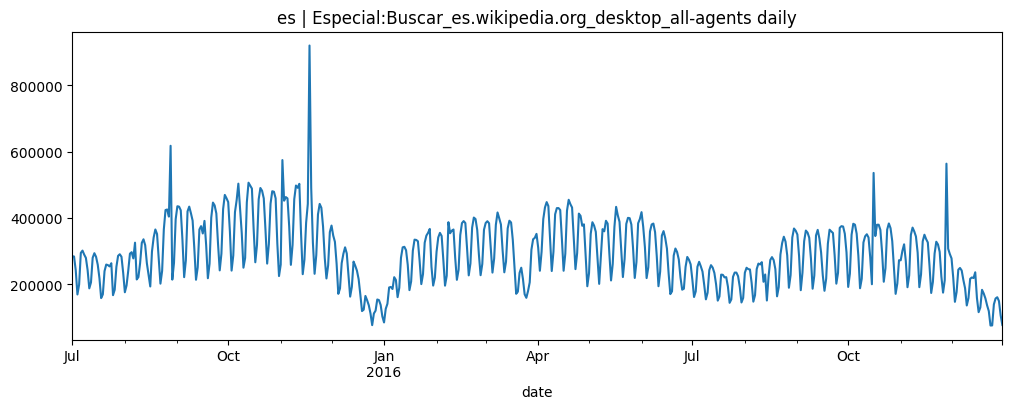

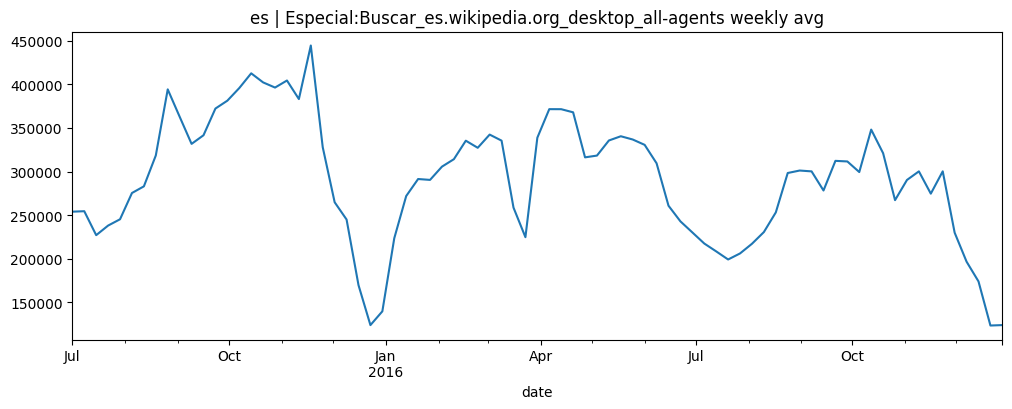

In [37]:
# Call function for each lang
for lang, dfs in lang_dfs.items():
    analyze_language_pages(
        lang=lang,
        dfs=dfs,
        top_n=5
    )


# Clean pages without null and duplicate

In [38]:
# Clean pages without null and duplicate
def clean_pages_no_nulls(df):
    return (
        df
        .drop_duplicates()
        .assign(_has_null=df.isna().any(axis=1))
        .groupby('page', group_keys=False)
        .filter(lambda g: not g['_has_null'].any())
        .drop(columns='_has_null')
    )
clean_ts = {}

for lang in final_ts.keys():
    clean_ts[lang] = clean_pages_no_nulls(final_ts[lang])


In [39]:
for lang, df in clean_ts.items():
    print(lang, "null rows:", df.isna().any(axis=1).sum())


en null rows: 0
fr null rows: 0
zh null rows: 0
ru null rows: 0
ja null rows: 0
de null rows: 0
es null rows: 0


In [40]:
{lang: df['page'].nunique() for lang, df in clean_ts.items()}


{'en': 1871,
 'fr': 2445,
 'zh': 12005,
 'ru': 2798,
 'ja': 16488,
 'de': 4290,
 'es': 3421}

In [41]:
## how many pages per language
TOP_PAGES = {
    'en': 300,
    'fr': 300,
    'zh': 700,
    'ru': 300,
    'de': 400,
    'ja': 800,
    'es': 300
}


In [42]:
## Function to get top pages for ONE language
def get_top_pages(df, n):
    return (
        df.groupby('page')['views']
        .sum()
        .sort_values(ascending=False)
        .head(n)
        .index
        .tolist()
    )


In [43]:
## Apply to ALL languages
top_pages_by_lang = {}

for lang, df in clean_ts.items():
    n = TOP_PAGES.get(lang, 300)   # default fallback
    top_pages_by_lang[lang] = get_top_pages(df, n)


In [44]:
## Example usage
top_pages_by_lang['en'][:10]


['Special:Search_en.wikipedia.org_all-access_all-agents',
 'Special:Search_en.wikipedia.org_desktop_all-agents',
 'Special:Search_en.wikipedia.org_mobile-web_all-agents',
 'Special:Book_en.wikipedia.org_all-access_all-agents',
 'Special:Book_en.wikipedia.org_desktop_all-agents',
 'Special:Search_en.wikipedia.org_all-access_spider',
 'XHamster_en.wikipedia.org_all-access_all-agents',
 'XHamster_en.wikipedia.org_mobile-web_all-agents',
 'Special:RecentChanges_en.wikipedia.org_all-access_all-agents',
 'Special:RecentChanges_en.wikipedia.org_desktop_all-agents']

In [45]:
len(top_pages_by_lang['ja'])


800

In [46]:
## Filter DataFrames to top pages only
top_ts = {}

for lang, df in clean_ts.items():
    pages = set(top_pages_by_lang[lang])
    top_ts[lang] = df[df['page'].isin(pages)]


In [47]:
## Optional: Aggregate “other pages” (long tail)
other_ts = {}

for lang, df in clean_ts.items():
    top_pages = set(top_pages_by_lang[lang])

    other_ts[lang] = (
        df[~df['page'].isin(top_pages)]
        .groupby('date', as_index=False)['views']
        .sum()
        .assign(page='__OTHER__')
    )


In [48]:
## Sanity checks
{lang: df['page'].nunique() for lang, df in top_ts.items()}


{'en': 300, 'fr': 300, 'zh': 700, 'ru': 300, 'ja': 800, 'de': 400, 'es': 300}

In [49]:
{lang: df.head(3) for lang, df in top_ts.items()}


{'en':                                                page title language  \
 624720  .xxx_en.wikipedia.org_all-access_all-agents  .xxx       en   
 625439  .xxx_en.wikipedia.org_all-access_all-agents  .xxx       en   
 626158  .xxx_en.wikipedia.org_all-access_all-agents  .xxx       en   
 
        access_type access_origin       date    views  
 624720  all-access    all-agents 2015-07-01  15408.0  
 625439  all-access    all-agents 2015-07-02  17375.0  
 626158  all-access    all-agents 2015-07-03  17334.0  ,
 'fr':                                             page title language access_type  \
 722700  @_fr.wikipedia.org_all-access_all-agents     @       fr  all-access   
 723344  @_fr.wikipedia.org_all-access_all-agents     @       fr  all-access   
 723988  @_fr.wikipedia.org_all-access_all-agents     @       fr  all-access   
 
        access_origin       date  views  
 722700    all-agents 2015-07-01  300.0  
 723344    all-agents 2015-07-02  420.0  
 723988    all-agents 2015-07

In [50]:
## Step 1: ADF test function (core)

from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())
    return {
        'adf_stat': result[0],
        'p_value': result[1],
        'is_stationary': result[1] < 0.05
    }


In [51]:
## Step 2: Stationarity check for ONE language
def stationarity_by_language(df):
    results = []

    for page, g in df.groupby('page'):
        s = (
            g.sort_values('date')
             .set_index('date')['views']
        )

        adf = adf_test(s)

        results.append({
            'page': page,
            'adf_stat': adf['adf_stat'],
            'p_value': adf['p_value'],
            'is_stationary': adf['is_stationary']
        })

    return pd.DataFrame(results)


In [52]:
## Step 3: Apply to ALL languages
stationarity_results = {}

for lang, df in top_ts.items():
    stationarity_results[lang] = stationarity_by_language(df)


In [53]:
## Step 4: Language-level summary (VERY IMPORTANT)
summary = []

for lang, res in stationarity_results.items():
    summary.append({
        'language': lang,
        'total_pages': len(res),
        'stationary_pages': res['is_stationary'].sum(),
        'non_stationary_pages': (~res['is_stationary']).sum(),
        'stationary_pct': round(res['is_stationary'].mean() * 100, 2)
    })

stationarity_summary = pd.DataFrame(summary)
stationarity_summary.sort_values('stationary_pct', ascending=False)


language  total_pages  stationary_pages  non_stationary_pages  \
0       en          300               251                    49   
5       de          400               312                    88   
4       ja          800               606                   194   
3       ru          300               220                    80   
1       fr          300               214                    86   
2       zh          700               465                   235   
6       es          300               175                   125   

   stationary_pct  
0           83.67  
5           78.00  
4           75.75  
3           73.33  
1           71.33  
2           66.43  
6           58.33

In [54]:
## Step 5: Differencing (when NOT stationary)

##Step 1: Differencing function
def difference_series(series, d=1):
    return series.diff(d).dropna()



In [55]:
## Step 2: Identify non-stationary pages per language
stationarity_results[lang]  # page-wise ADF results

#Extract non-stationary pages:
non_stationary_pages = {
    lang: set(
        res.loc[~res['is_stationary'], 'page']
    )
    for lang, res in stationarity_results.items()
}



In [56]:
##Step 3: Apply differencing ONLY where needed
diff_ts = {}

for lang, df in top_ts.items():
    ns_pages = non_stationary_pages.get(lang, set())

    transformed = []

    for page, g in df.groupby('page'):
        g = g.sort_values('date')

        if page in ns_pages:
            # apply differencing
            s = difference_series(g['views'], d=1)

            g = (
                g.loc[g.index[1:]]   # align after diff
                .assign(views=s.values, diff_order=1)
            )
        else:
            # keep original
            g = g.assign(diff_order=0)

        transformed.append(g)

    diff_ts[lang] = pd.concat(transformed, ignore_index=True)


In [57]:
## Step 4: Verify correctness
# no missing values introduced by differencing
for lang, df in diff_ts.items():
    print(lang, df['views'].isna().sum())


en 0
fr 0
zh 0
ru 0
ja 0
de 0
es 0


In [58]:
## Step 5: Quick sanity check (counts)
for lang, df in diff_ts.items():
    print(lang, df['diff_order'].value_counts())


en diff_order
0    138050
1     26901
Name: count, dtype: int64
fr diff_order
0    117700
1     47214
Name: count, dtype: int64
zh diff_order
0    255750
1    129015
Name: count, dtype: int64
ru diff_order
0    121000
1     43920
Name: count, dtype: int64
ja diff_order
0    333300
1    106506
Name: count, dtype: int64
de diff_order
0    171600
1     48312
Name: count, dtype: int64
es diff_order
0    96250
1    68625
Name: count, dtype: int64


In [59]:
##Step 1: Run ADF on DIFFERENCED data
stationarity_results_diff = {}

for lang, df in diff_ts.items():
    res = []

    for page, g in df.groupby('page'):
        s = (
            g.sort_values('date')
             .set_index('date')['views']
        )

        adf = adf_test(s)

        res.append({
            'page': page,
            'adf_stat': adf['adf_stat'],
            'p_value': adf['p_value'],
            'is_stationary': adf['is_stationary']
        })

    stationarity_results_diff[lang] = pd.DataFrame(res)


In [60]:
## Step 2: Recompute NEW summary
summary_diff = []

for lang, res in stationarity_results_diff.items():
    summary_diff.append({
        'language': lang,
        'total_pages': len(res),
        'stationary_pages': res['is_stationary'].sum(),
        'non_stationary_pages': (~res['is_stationary']).sum(),
        'stationary_pct': round(res['is_stationary'].mean() * 100, 2)
    })

stationarity_summary_diff = pd.DataFrame(summary_diff)
stationarity_summary_diff


language  total_pages  stationary_pages  non_stationary_pages  \
0       en          300               300                     0   
1       fr          300               300                     0   
2       zh          700               699                     1   
3       ru          300               300                     0   
4       ja          800               800                     0   
5       de          400               399                     1   
6       es          300               300                     0   

   stationary_pct  
0          100.00  
1          100.00  
2           99.86  
3          100.00  
4          100.00  
5           99.75  
6          100.00

In [61]:
df['diff_order']  # 0 or 1


0         0
1         0
2         0
3         0
4         0
         ..
164870    0
164871    0
164872    0
164873    0
164874    0
Name: diff_order, Length: 164875, dtype: int64

In [62]:
## Step 1: Extract remaining non-stationary pages
problem_pages = {
    lang: res.loc[~res['is_stationary'], 'page'].tolist()
    for lang, res in stationarity_results_diff.items()
}
problem_pages

{'en': [],
 'fr': [],
 'zh': ['刺客教條系列_zh.wikipedia.org_all-access_all-agents'],
 'ru': [],
 'ja': [],
 'de': ['Hauptseite_de.wikipedia.org_all-access_all-agents'],
 'es': []}

In [63]:
## Decomposition (trend / seasonality / residual)

## Step 1 Helper – get a clean page series
def get_page_series(df, page):
    return (
        df[df['page'] == page]
        .sort_values('date')
        .set_index('date')['views']
    )


In [64]:
## Step 2: Select 3 representative pages per language

sample_pages = {}

for lang, df in top_ts.items():
    agg = df.groupby('page')['views'].sum().sort_values(ascending=False)

    top_page = agg.index[0]
    mid_page = agg.index[len(agg) // 2]

    # page that was non-stationary BEFORE differencing
    non_stat = stationarity_results[lang].loc[
        ~stationarity_results[lang]['is_stationary'], 'page'
    ]

    diff_page = non_stat.iloc[0] if len(non_stat) > 0 else None

    pages = [top_page, mid_page]
    if diff_page and diff_page not in pages:
        pages.append(diff_page)

    sample_pages[lang] = pages[:3]


In [65]:
## Step 3: Decompose each selected pages (trend / seasonality / residual)

from statsmodels.tsa.seasonal import seasonal_decompose
#import matplotlib.pyplot as plt

def decompose_page(series, period=7):
    return seasonal_decompose(
        series,
        model='additive',
        period=period,
        extrapolate_trend='freq'
    )



Language: en


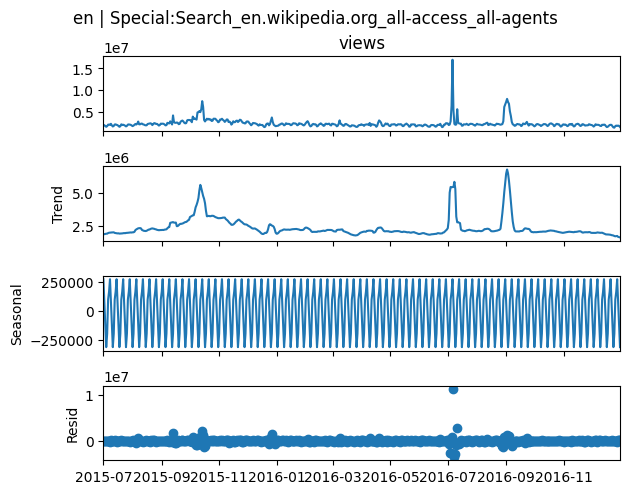

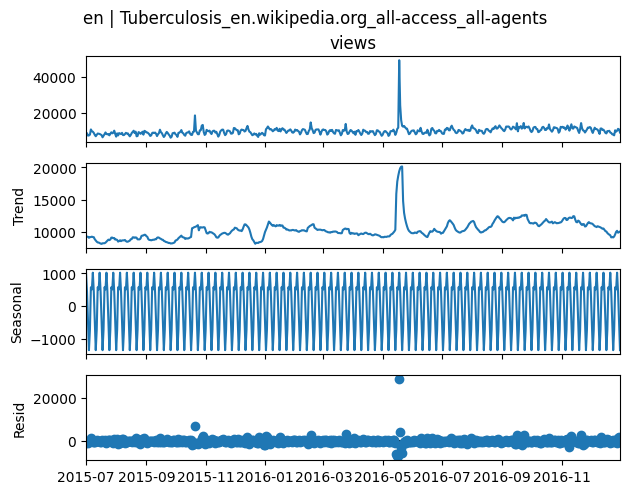

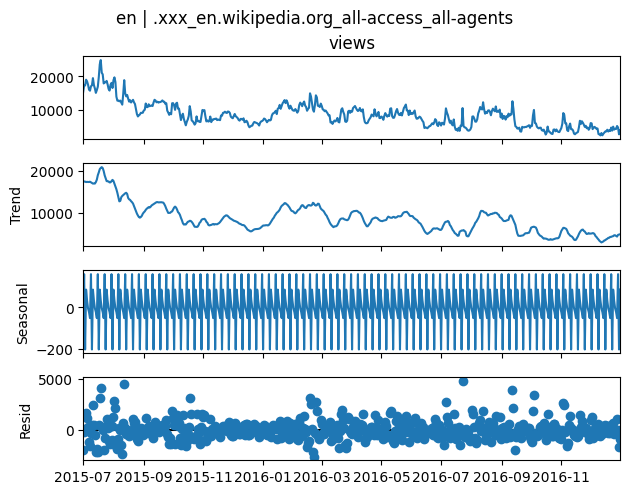


Language: fr


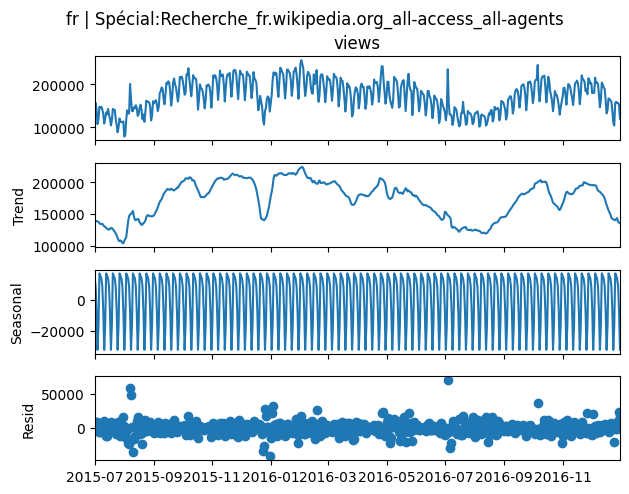

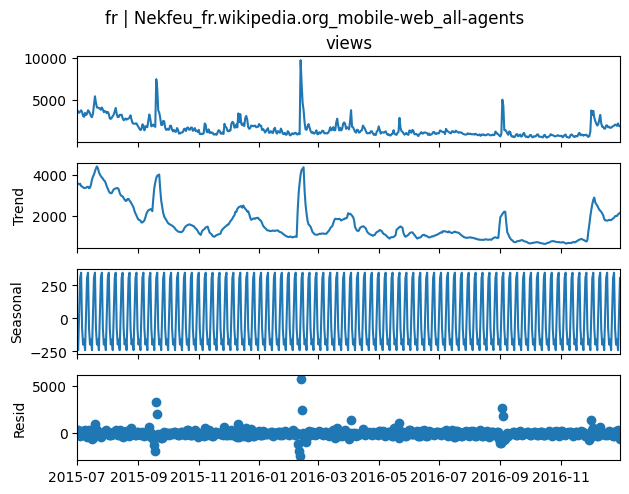

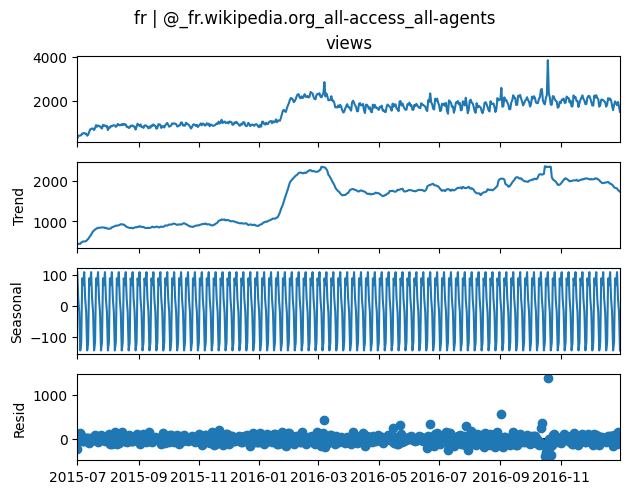


Language: zh


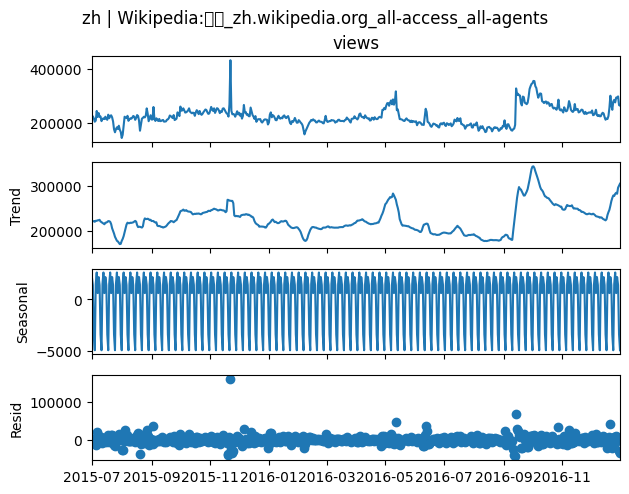

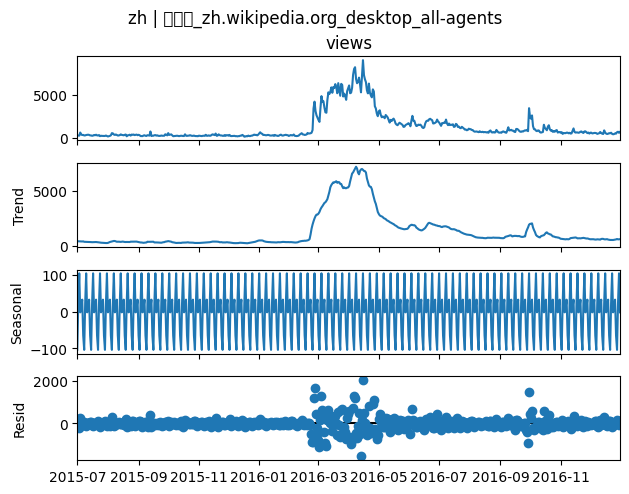

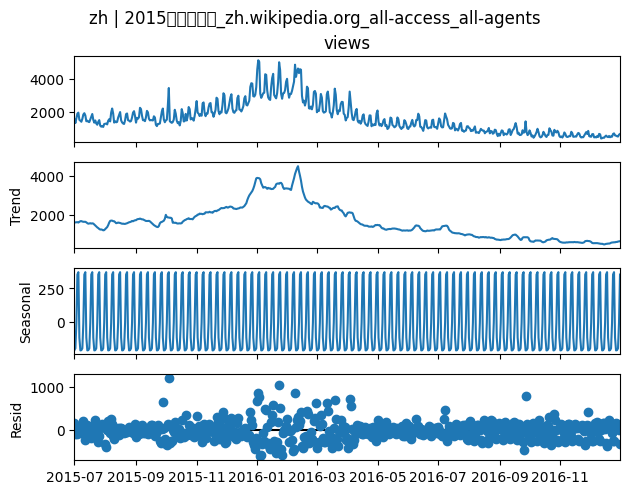


Language: ru


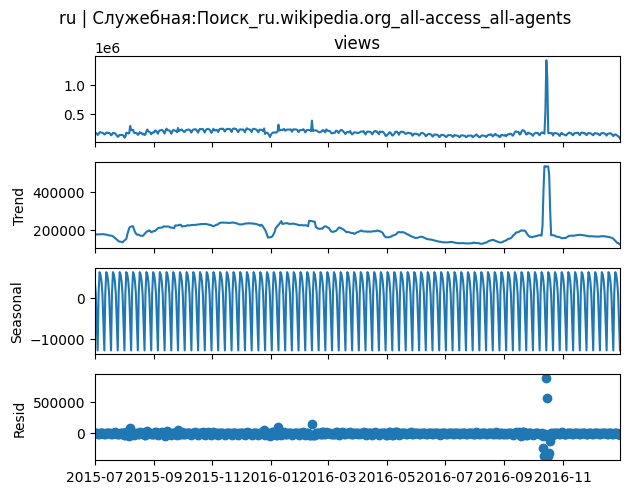

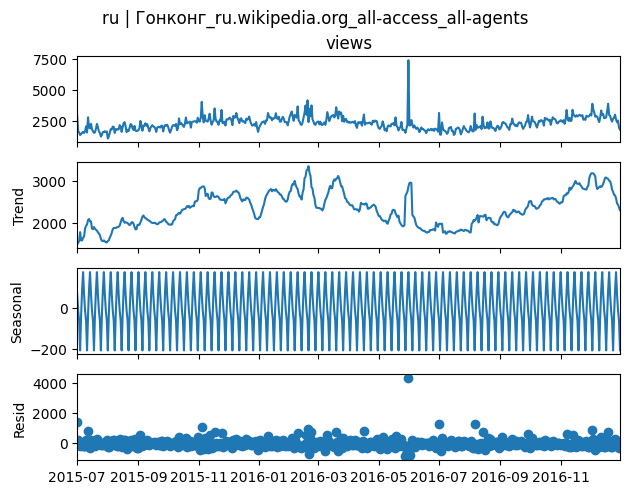

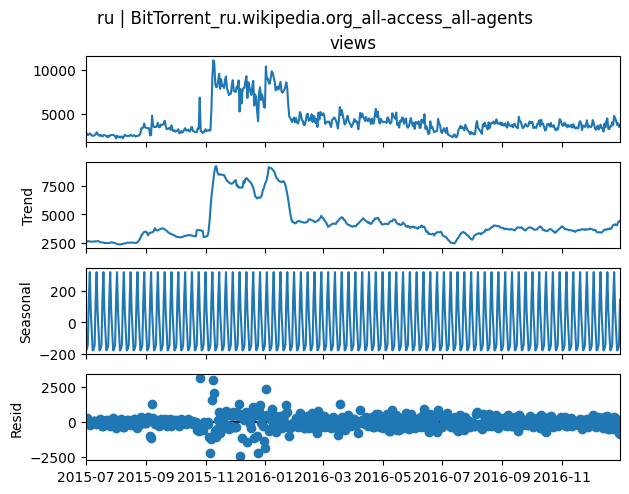


Language: ja


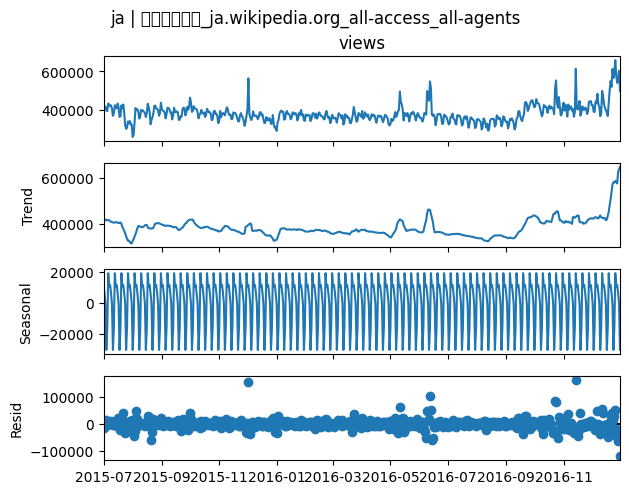

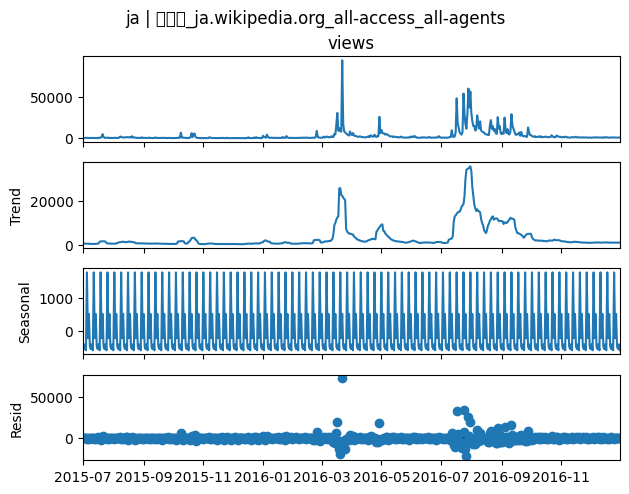

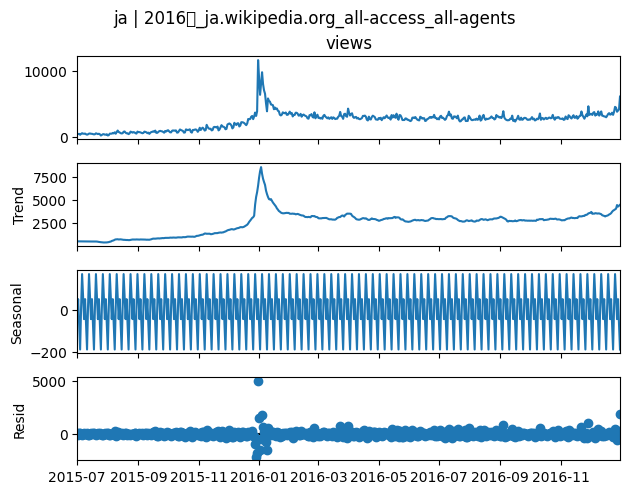


Language: de


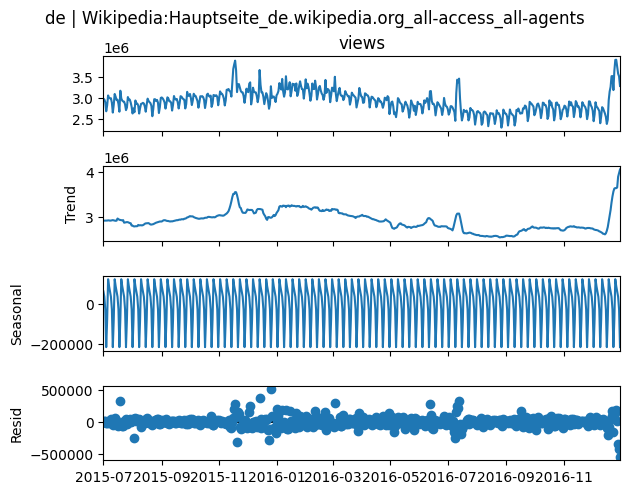

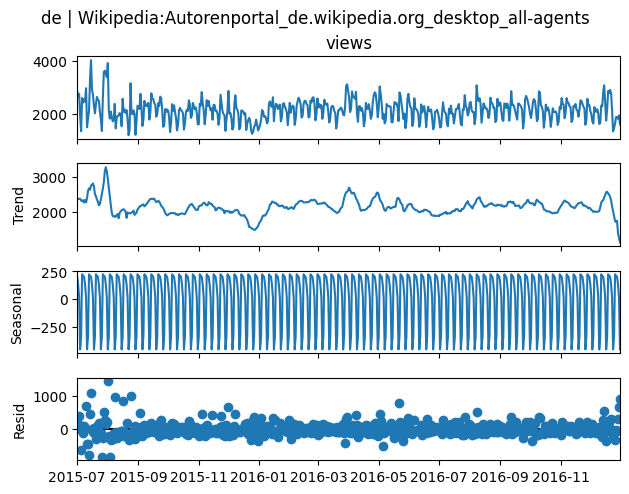

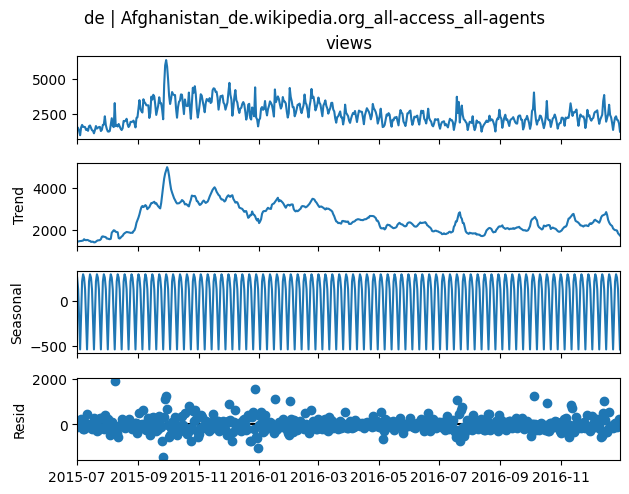


Language: es


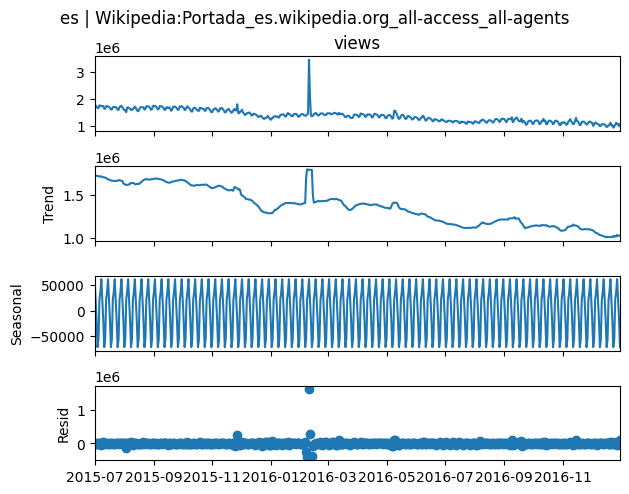

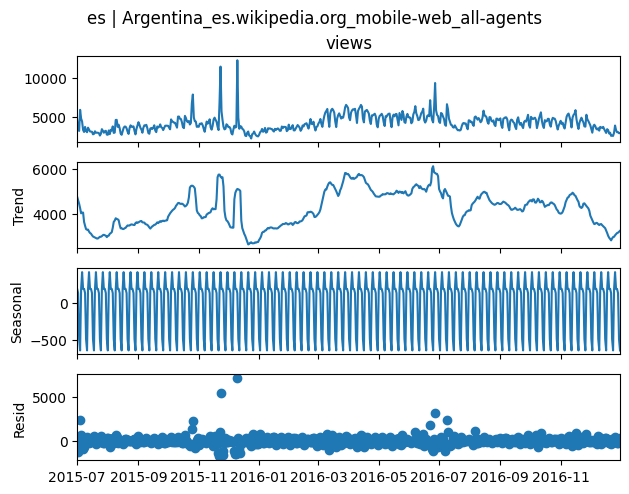

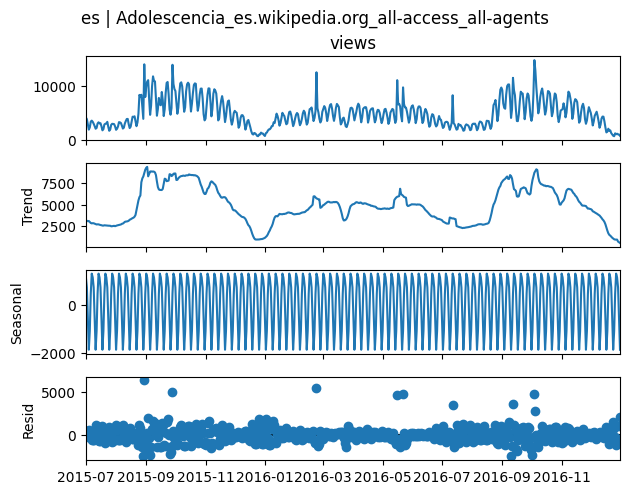

In [66]:
for lang, pages in sample_pages.items():
    print(f"\nLanguage: {lang}")

    for page in pages:
        s = get_page_series(top_ts[lang], page)

        decomp = decompose_page(s, period=7)

        decomp.plot()
        plt.suptitle(f"{lang} | {page}", y=1.02)
        plt.show()


In [67]:
#Helper functions


## Plot ACF & PACF for 3 pages per language

def plot_acf_pacf(series, lags=30, title=""):
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))

    plot_acf(series, lags=lags, ax=ax[0])
    plot_pacf(series, lags=lags, ax=ax[1], method='ywm')

    ax[0].set_title("ACF")
    ax[1].set_title("PACF")

    plt.suptitle(title)
    plt.show()


Language: en


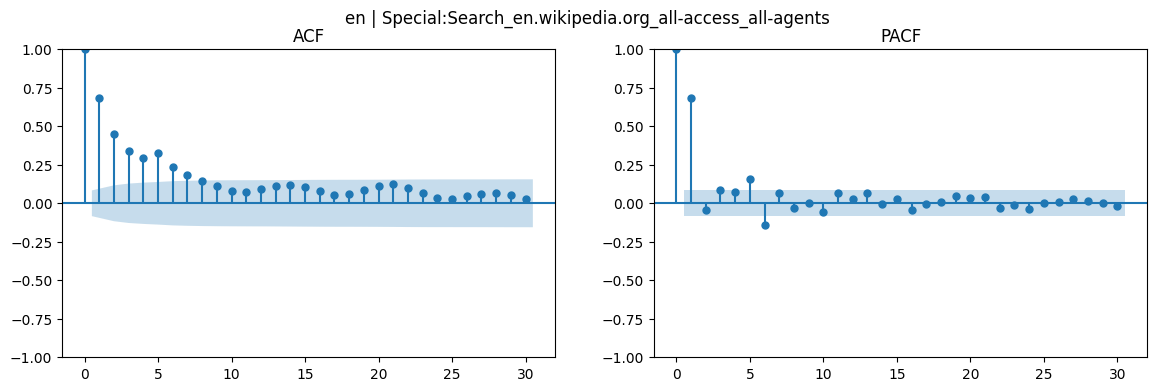

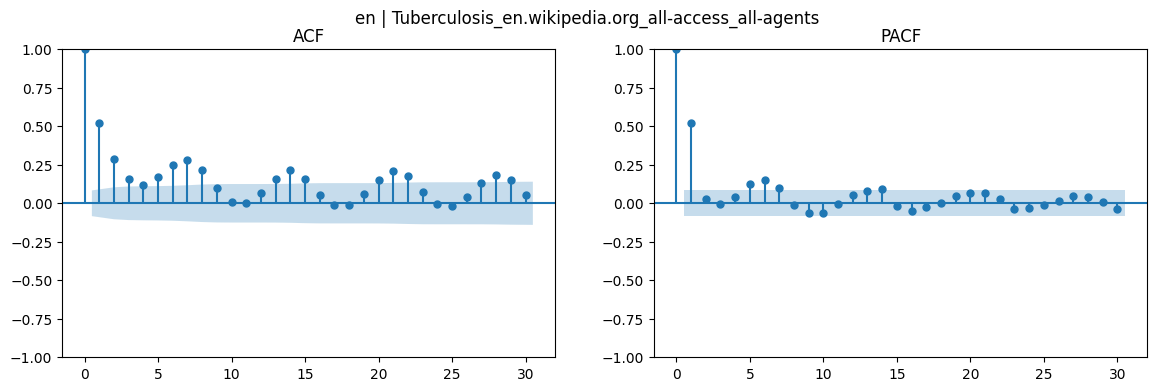

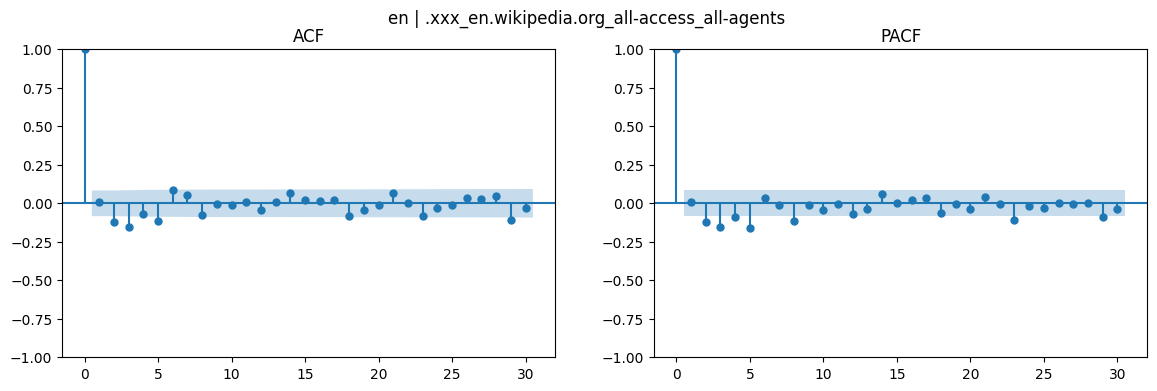


Language: fr


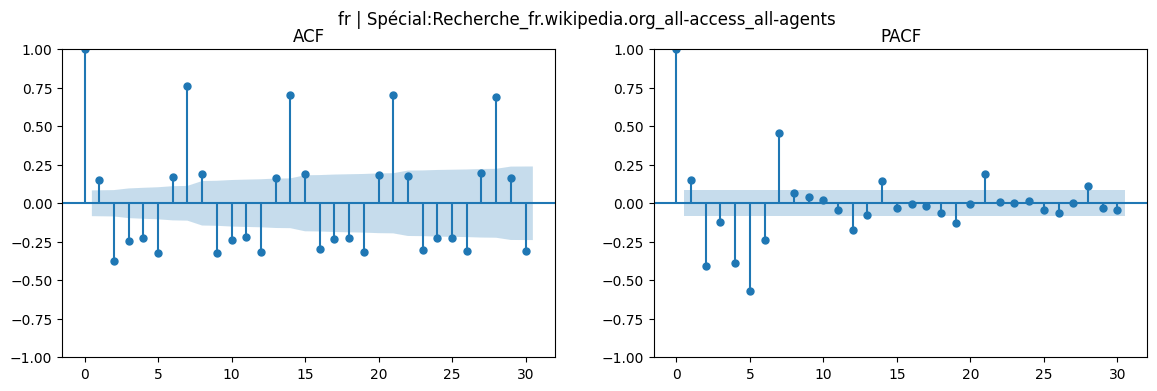

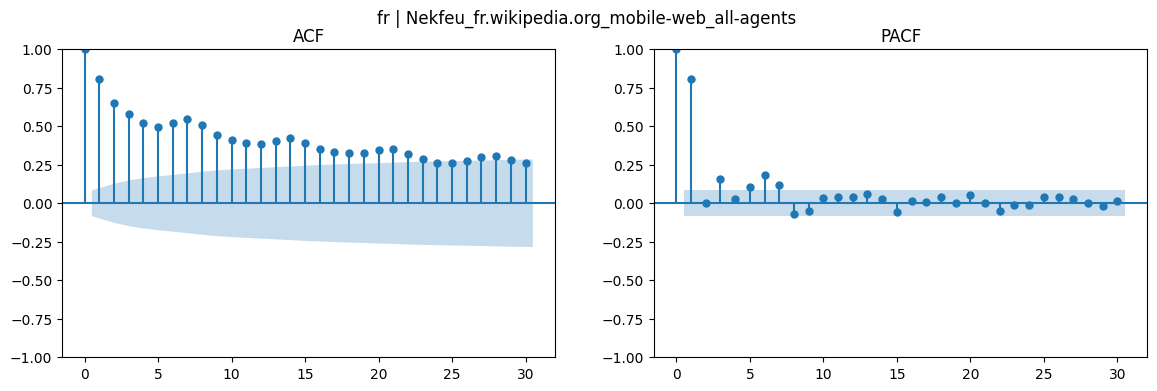

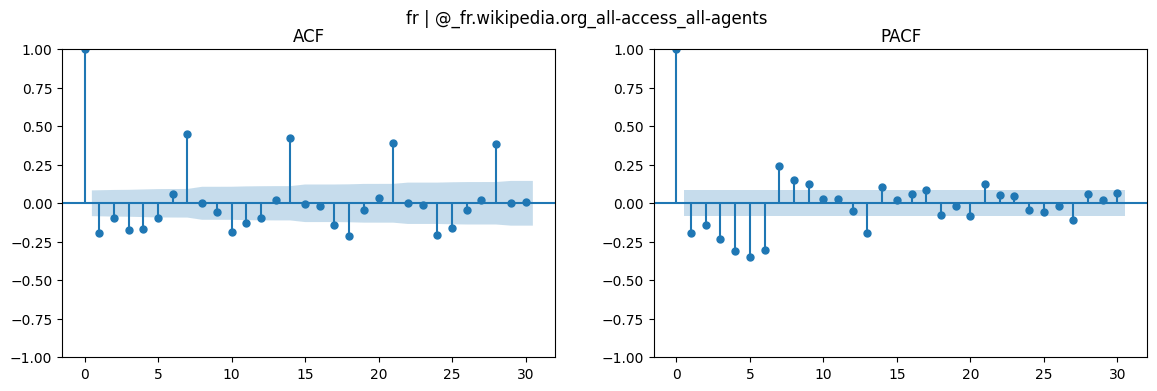


Language: zh


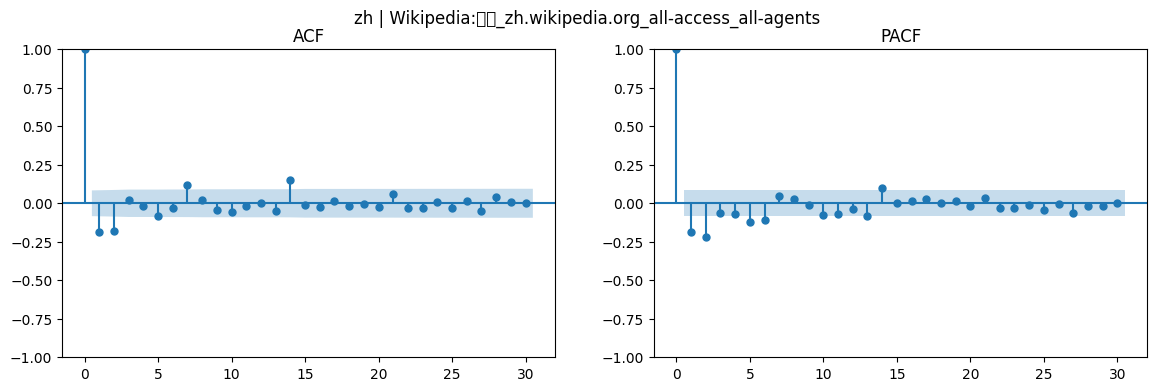

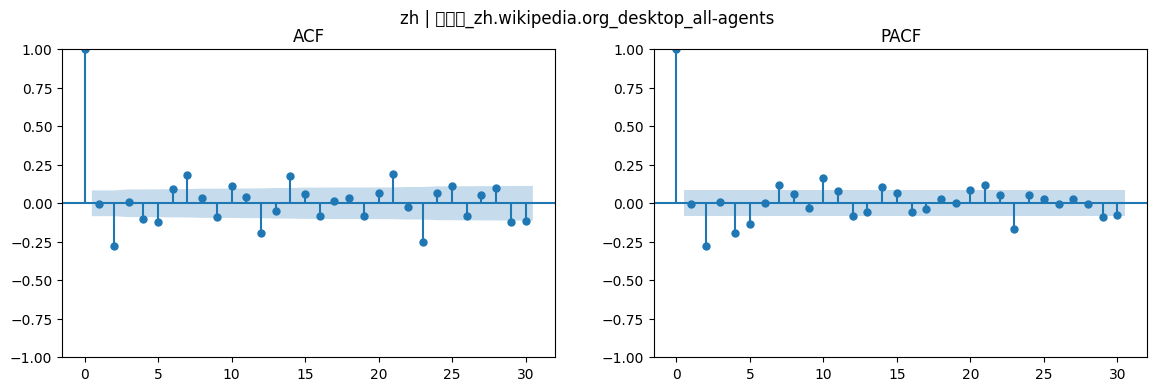

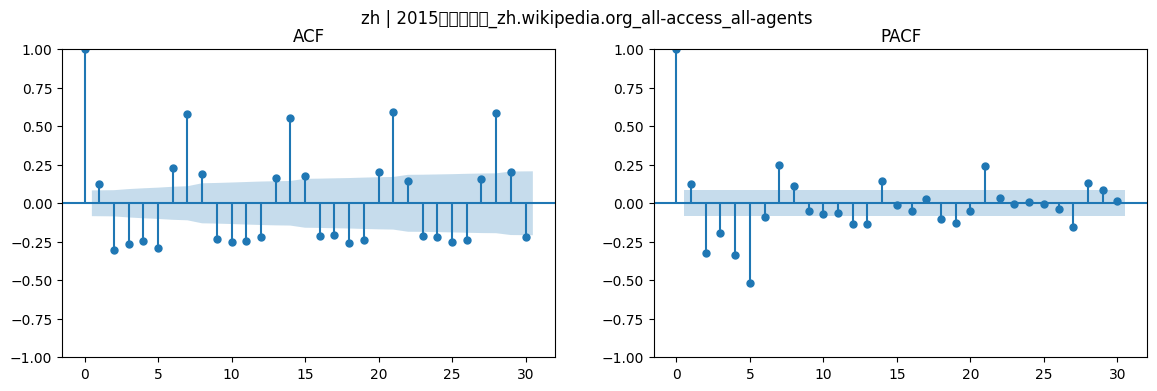


Language: ru


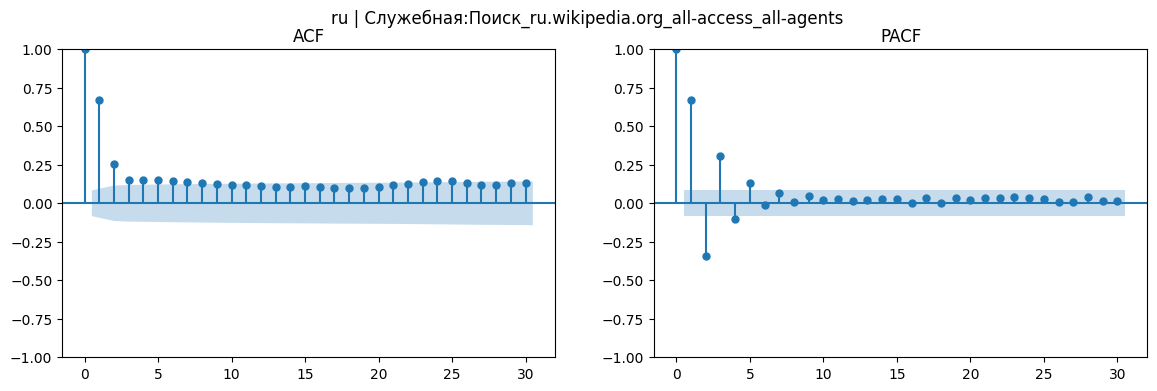

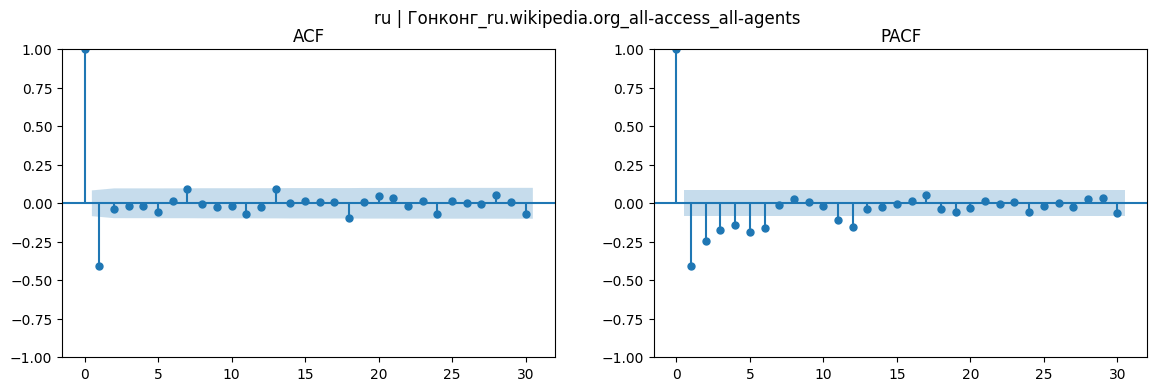

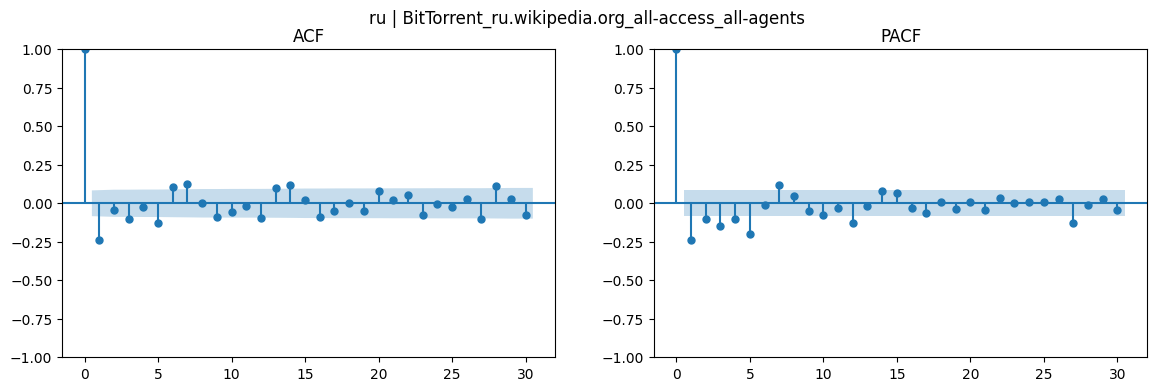


Language: ja


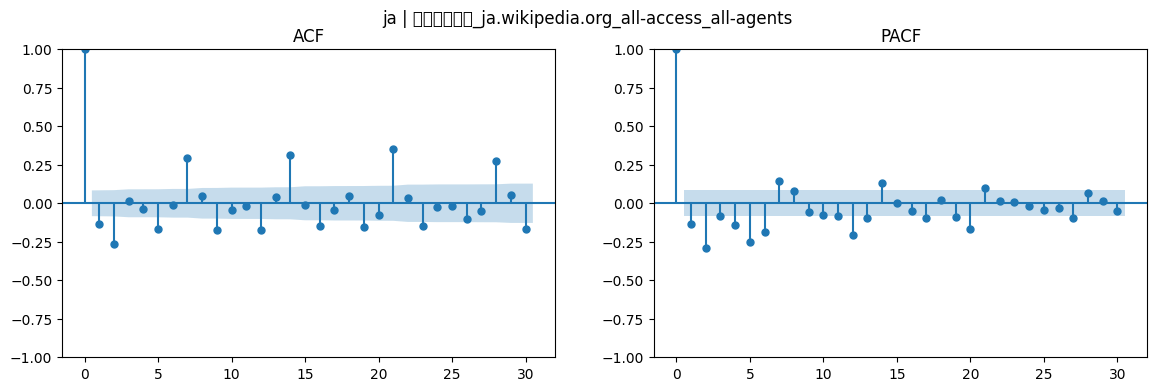

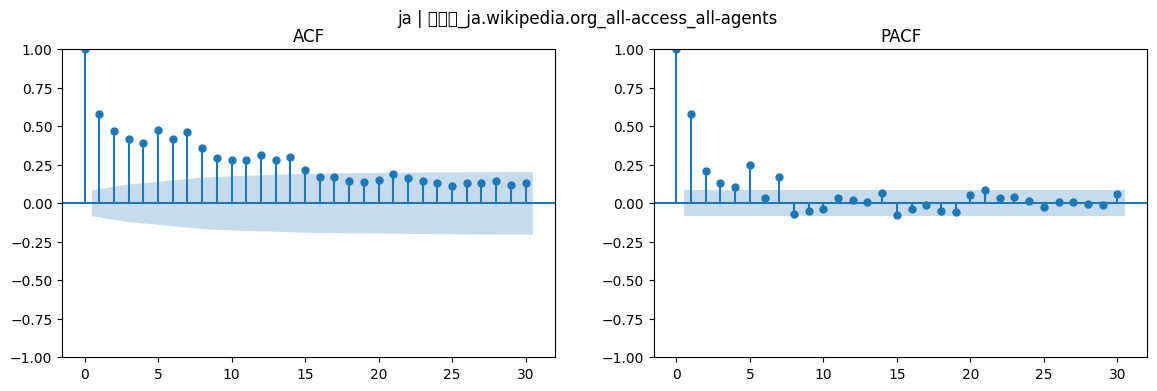

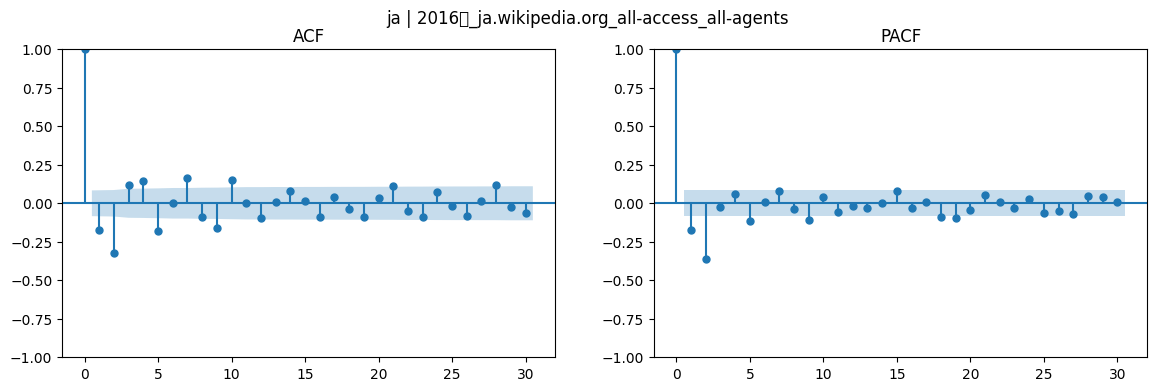


Language: de


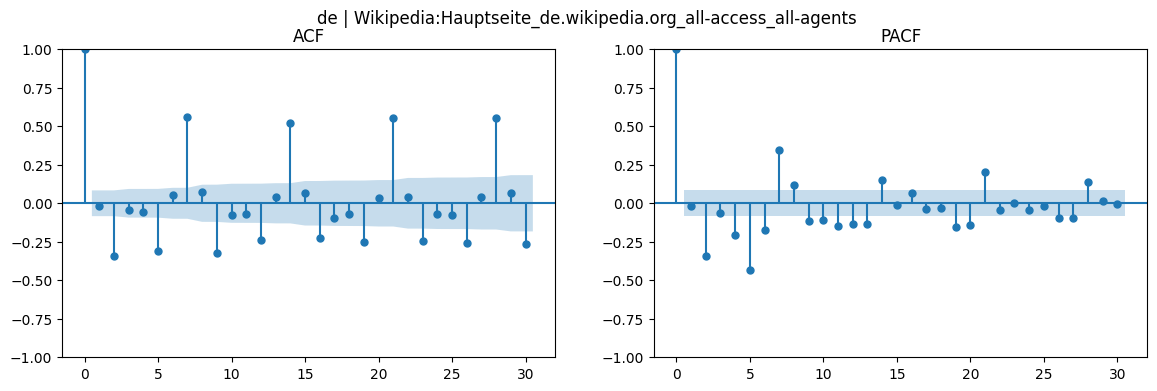

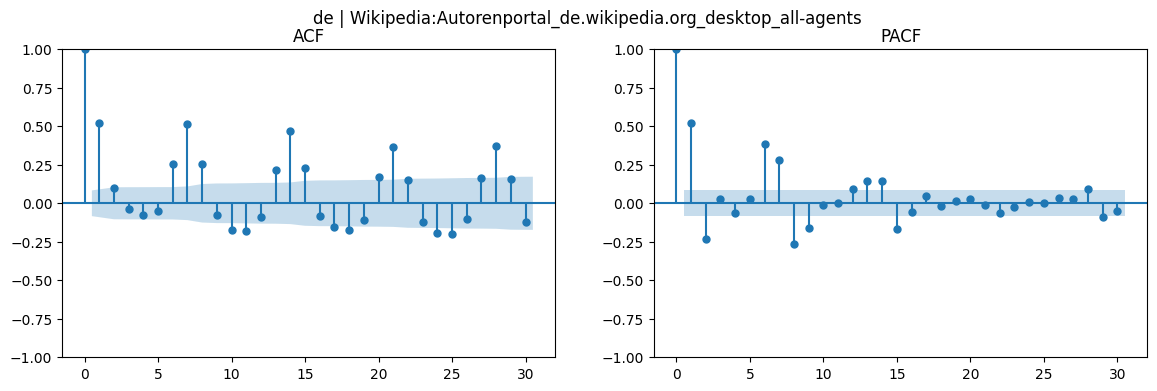

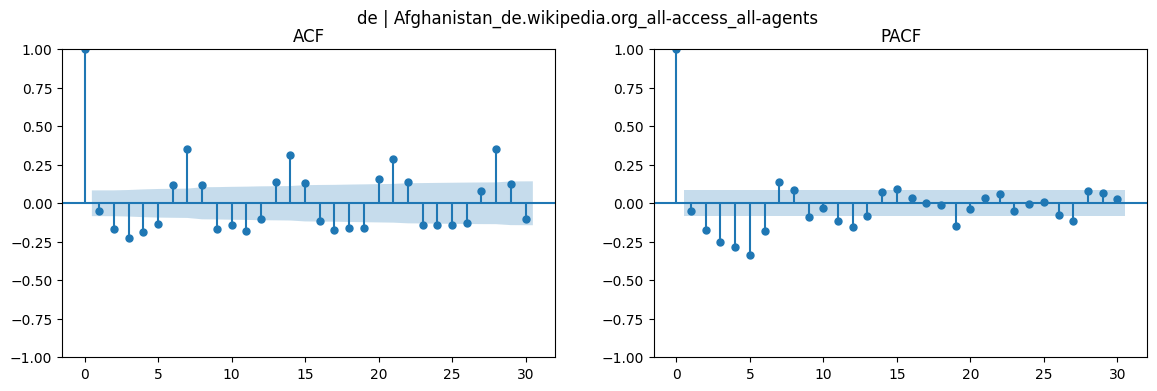


Language: es


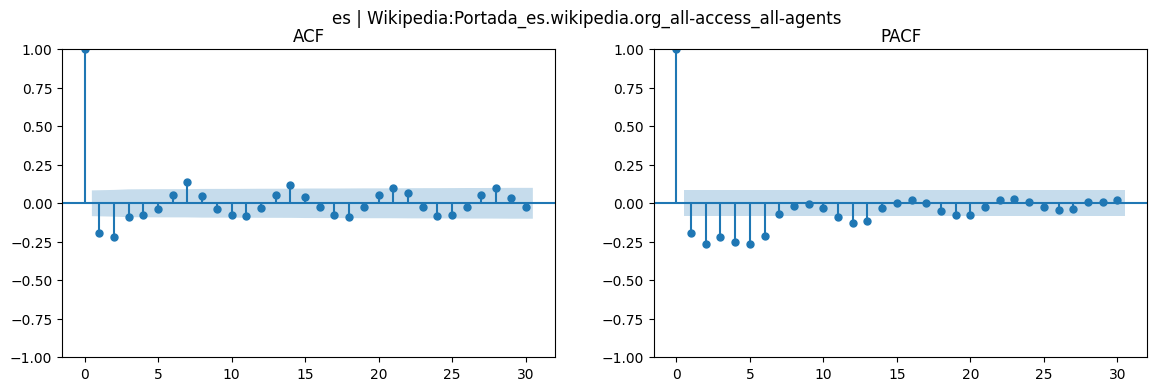

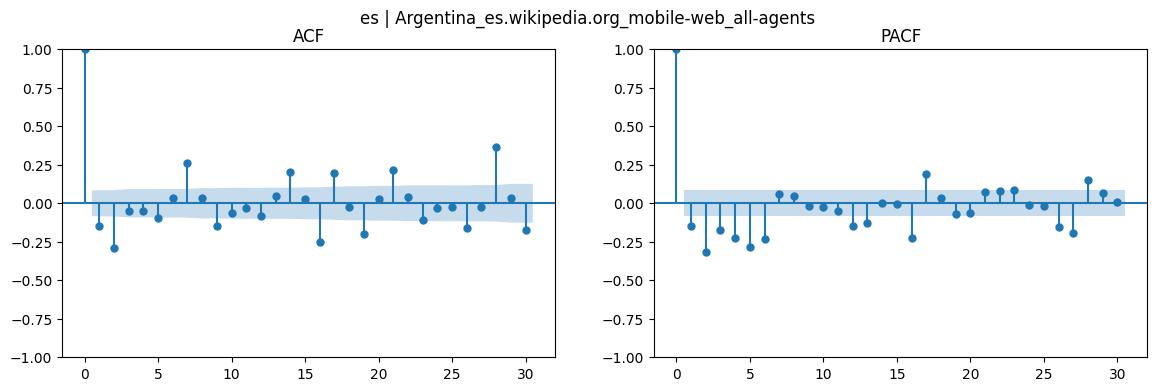

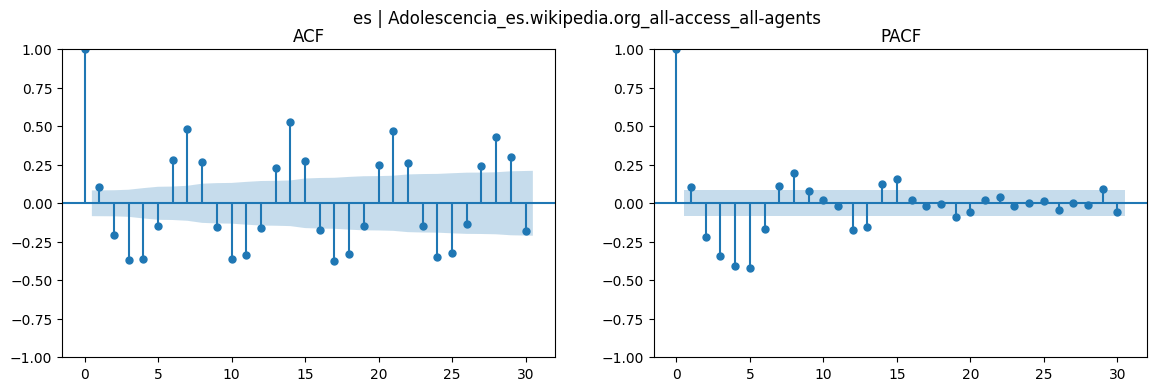

In [68]:
for lang, pages in sample_pages.items():
    print(f"\nLanguage: {lang}")

    for page in pages:
        s = get_page_series(diff_ts[lang], page)

        plot_acf_pacf(
            s,
            lags=30,
            title=f"{lang} | {page}"
        )


#ARIMA

In [77]:
## mape

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [78]:
## Train–test split (time-aware)
def train_test_split_ts(series, test_size=0.2):
    n_test = int(len(series) * test_size)
    return series[:-n_test], series[-n_test:]



In [79]:
## Fit ARIMA + evaluate
def run_arima(series):
    train, test = train_test_split_ts(series)

    model = ARIMA(train, order=(1,0,1))
    fit = model.fit()
    forecast = fit.forecast(len(test))

    return test, forecast


In [80]:
## SARIMA (with seasonality)
def run_sarima(series):
    train, test = train_test_split_ts(series)

    model = SARIMAX(
        train,
        order=(1,0,1),
        seasonal_order=(1,1,1,7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fit = model.fit(disp=False)
    forecast = fit.forecast(len(test))

    return test, forecast


##SARIMAX (with exogenous variable)

In [81]:
##SARIMAX (with exogenous variable)
def run_sarimax(series):
    train, test = train_test_split_ts(series)

    exog = pd.DataFrame({'t': np.arange(len(series))}, index=series.index)
    exog_train, exog_test = train_test_split_ts(exog['t'])

    model = SARIMAX(
        train,
        exog=exog_train,
        order=(1,0,1),
        seasonal_order=(1,1,1,7)
    )
    fit = model.fit(disp=False)
    forecast = fit.forecast(len(test), exog=exog_test)

    return test, forecast


In [82]:
## Prophet
def run_prophet(series):
    df = series.reset_index()
    df.columns = ['ds', 'y']

    split = int(len(df) * 0.8)
    train, test = df.iloc[:split], df.iloc[split:]

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )

    model.fit(train)

    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)

    y_pred = forecast['yhat'].iloc[-len(test):].values
    y_true = test['y'].values

    return y_true, y_pred


In [85]:
## Full Model Comparison Loop
results = []

for lang, pages in sample_pages.items():
    df = final_ts[lang]   # use original scale for forecasting

    for page in pages:
        series = get_page_series(df, page)

        if len(series) < 60:
            continue

        models = {
            'ARIMA': run_arima,
            'SARIMA': run_sarima,
            'SARIMAX': run_sarimax,
            'Prophet': run_prophet
        }

        for model_name, func in models.items():
            try:
                y_true, y_pred = func(series)

                results.append({
                    'language': lang,
                    'page': page,
                    'model': model_name,
                    'MAE': round(mae(y_true, y_pred), 2),
                    'MSE': round(mse(y_true, y_pred), 2),
                    'MAPE (%)': round(mape(y_true, y_pred), 2)
                })

            except Exception as e:
                print(f"{lang} | {page} | {model_name} failed:", e)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

In [86]:
## Comparison Tables

## Per-model performance
results_df = pd.DataFrame(results)
print(results_df)

##Average by model
results_df.groupby('model')[['MAE','MSE','MAPE (%)']].mean().sort_values('MAPE (%)')
print(results_df)


##Average by language & model
results_df.groupby(['language','model'])[['MAE','MSE','MAPE (%)']].mean()
print(results_df)


   language                                               page    model  \
0        en  Special:Search_en.wikipedia.org_all-access_all...    ARIMA   
1        en  Special:Search_en.wikipedia.org_all-access_all...   SARIMA   
2        en  Special:Search_en.wikipedia.org_all-access_all...  SARIMAX   
3        en  Special:Search_en.wikipedia.org_all-access_all...  Prophet   
4        en  Tuberculosis_en.wikipedia.org_all-access_all-a...    ARIMA   
..      ...                                                ...      ...   
79       es   Argentina_es.wikipedia.org_mobile-web_all-agents  Prophet   
80       es  Adolescencia_es.wikipedia.org_all-access_all-a...    ARIMA   
81       es  Adolescencia_es.wikipedia.org_all-access_all-a...   SARIMA   
82       es  Adolescencia_es.wikipedia.org_all-access_all-a...  SARIMAX   
83       es  Adolescencia_es.wikipedia.org_all-access_all-a...  Prophet   

           MAE           MSE  MAPE (%)  
0    432036.08  2.329595e+11     22.80  
1    862208.23  7